# NYC Taxi Demand Analysis using PySpark
## Big Data Project - CSGY 6513

**Analysis Period:** September 2023 - February 2024  
**Data Source:** NYC TLC Yellow Taxi Trip Records  
**Framework:** Apache Spark (PySpark)


Jishnu Warrier- jrw9715  
Neha Patil- np2998  
Ruchi Jha- rj2807  

### Project Overview
This notebook analyzes NYC Yellow Taxi demand patterns using geo-spatial and temporal data. We process trip records using PySpark for scalable data processing, perform feature engineering, and train machine learning models to predict taxi demand.

### Table of Contents
1. [Environment Setup](#1-environment-setup)
2. [Data Loading](#2-data-loading)
3. [Data Cleaning](#3-data-cleaning)
4. [Exploratory Data Analysis](#4-exploratory-data-analysis)
5. [Zone-Hour Aggregation](#5-zone-hour-aggregation)
6. [Weather Data Integration](#6-weather-data-integration)
7. [Feature Engineering](#7-feature-engineering)
8. [Machine Learning with Spark MLlib](#8-machine-learning)
9. [Model Evaluation & Results](#9-model-evaluation)
10. [Export for Dashboard](#10-export-for-dashboard)

---
## 1. Environment Setup <a name="1-environment-setup"></a>

Set up the PySpark environment, import required libraries, and initialize the Spark session that will be used for all downstream data processing and modeling.

In [ ]:
!pip install pyspark==3.5.0 pandas pyarrow meteostat requests tqdm matplotlib seaborn folium -q

print(" All packages installed successfully")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires pyspark[connect]~=3.5.1, but you have pyspark 3.5.0 which is incompatible.
 All packages installed successfully


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import *

from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import requests
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

print(" All imports successful")

 All imports successful


In [ ]:
# Initialize Spark Session with optimized configuration
spark = SparkSession.builder \
    .appName("NYC_Taxi_Demand_Analysis") \
    .config("spark.driver.memory", "10g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "50") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.sql.parquet.compression.codec", "snappy") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to reduce verbosity
spark.sparkContext.setLogLevel("WARN")

print("=" * 70)
print("SPARK SESSION INITIALIZED")
print("=" * 70)
print(f"Spark Version: {spark.version}")
print(f"Spark Master: {spark.sparkContext.master}")
print(f"Available Cores: {spark.sparkContext.defaultParallelism}")
print(f"Driver Memory: {spark.conf.get('spark.driver.memory')}")
print("=" * 70)

SPARK SESSION INITIALIZED
Spark Version: 3.5.0
Spark Master: local[*]
Available Cores: 2
Driver Memory: 10g


---
## 2. Data Loading <a name="2-data-loading"></a>

Load the raw NYC yellow taxi trip records for the selected period and perform a basic sanity check on row counts and schema to verify that the data was read correctly.


In [ ]:
# Data download utility function
def download_file(url, filename):
    """Download file with progress bar"""
    if os.path.exists(filename):
        print(f"  Skipping {filename} (already exists)")
        return True

    print(f"\n Downloading: {filename}")
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        total_size = int(response.headers.get('content-length', 0))

        with open(filename, 'wb') as file, tqdm(
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
            desc=filename
        ) as pbar:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
                pbar.update(len(chunk))

        print(f" Downloaded: {filename}")
        return True
    except Exception as e:
        print(f" Error downloading {filename}: {str(e)}")
        return False

print(" Download function ready")

 Download function ready


In [ ]:
# Download NYC Yellow Taxi Data (September 2023 - February 2024)
months = ['2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-02']

print("=" * 70)
print("DOWNLOADING NYC YELLOW TAXI DATA (6 MONTHS)")
print("=" * 70)

downloaded_files = []
for month in months:
    # Revert to parquet filename and URL
    filename = f"yellow_tripdata_{month}.parquet"
    url = f"https://d37ci6vzurychx.cloudfront.net/trip-data/{filename}"
    if download_file(url, filename):
        downloaded_files.append(filename)

# Download taxi zone lookup
download_file(
    "https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv",
    "taxi_zone_lookup.csv"
)

print("\n" + "=" * 70)
print(f" DOWNLOAD COMPLETE: {len(downloaded_files)} trip files + zone lookup")
print("=" * 70)


# Display file sizes
print("\n File Sizes:")
for filename in downloaded_files:
    csv_name = filename.replace(".parquet", ".csv")
    df = pd.read_parquet(filename)
    df.to_csv(csv_name, index=False)
    size_mb = os.path.getsize(csv_name) / (1024 * 1024)
    print(f"   {csv_name}: {size_mb:.1f} MB")

DOWNLOADING NYC YELLOW TAXI DATA (6 MONTHS)

 Downloading: yellow_tripdata_2023-09.parquet


yellow_tripdata_2023-09.parquet: 100%|██████████| 45.7M/45.7M [00:00<00:00, 66.7MB/s]


 Downloaded: yellow_tripdata_2023-09.parquet

 Downloading: yellow_tripdata_2023-10.parquet


yellow_tripdata_2023-10.parquet: 100%|██████████| 56.3M/56.3M [00:00<00:00, 91.5MB/s]


 Downloaded: yellow_tripdata_2023-10.parquet

 Downloading: yellow_tripdata_2023-11.parquet


yellow_tripdata_2023-11.parquet: 100%|██████████| 53.5M/53.5M [00:00<00:00, 84.9MB/s]


 Downloaded: yellow_tripdata_2023-11.parquet

 Downloading: yellow_tripdata_2023-12.parquet


yellow_tripdata_2023-12.parquet: 100%|██████████| 54.2M/54.2M [00:00<00:00, 83.1MB/s]


 Downloaded: yellow_tripdata_2023-12.parquet

 Downloading: yellow_tripdata_2024-01.parquet


yellow_tripdata_2024-01.parquet: 100%|██████████| 47.6M/47.6M [00:00<00:00, 85.4MB/s]


 Downloaded: yellow_tripdata_2024-01.parquet

 Downloading: yellow_tripdata_2024-02.parquet


yellow_tripdata_2024-02.parquet: 100%|██████████| 48.0M/48.0M [00:00<00:00, 83.6MB/s]


 Downloaded: yellow_tripdata_2024-02.parquet

 Downloading: taxi_zone_lookup.csv


taxi_zone_lookup.csv: 12.0kB [00:00, 317kB/s]


 Downloaded: taxi_zone_lookup.csv

 DOWNLOAD COMPLETE: 6 trip files + zone lookup

 File Sizes:
   yellow_tripdata_2023-09.csv: 284.6 MB
   yellow_tripdata_2023-10.csv: 352.3 MB
   yellow_tripdata_2023-11.csv: 334.2 MB
   yellow_tripdata_2023-12.csv: 337.2 MB
   yellow_tripdata_2024-01.csv: 296.2 MB
   yellow_tripdata_2024-02.csv: 300.0 MB


In [ ]:
# Load data with PySpark
print("=" * 70)
print("LOADING DATA WITH PYSPARK")
print("=" * 70)

# Load all 6 months
dfs = []
for month in months:
    # Revert to parquet filename and read as parquet
    filename = f"yellow_tripdata_{month}.parquet"
    df = spark.read.parquet(filename)
    record_count = df.count()
    print(f" Loaded {month}: {record_count:,} records")
    dfs.append(df)

# Union all months
df_spark = dfs[0]
for df in dfs[1:]:
    df_spark = df_spark.union(df)

# Cache the dataframe for faster operations
df_spark = df_spark.cache()
total_records = df_spark.count()

print(f"\n Total Records: {total_records:,}")
print("=" * 70)

LOADING DATA WITH PYSPARK
 Loaded 2023-09: 2,846,722 records
 Loaded 2023-10: 3,522,285 records
 Loaded 2023-11: 3,339,715 records
 Loaded 2023-12: 3,376,567 records
 Loaded 2024-01: 2,964,624 records
 Loaded 2024-02: 3,007,526 records

 Total Records: 19,057,439


In [ ]:
# Load taxi zone lookup
zones_df = spark.read.csv("taxi_zone_lookup.csv", header=True, inferSchema=True)

print("\n Taxi Zones Schema:")
zones_df.printSchema()

print("\n Sample Zones:")
zones_df.show(10, truncate=False)


 Taxi Zones Schema:
root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)


 Sample Zones:
+----------+-------------+-----------------------+------------+
|LocationID|Borough      |Zone                   |service_zone|
+----------+-------------+-----------------------+------------+
|1         |EWR          |Newark Airport         |EWR         |
|2         |Queens       |Jamaica Bay            |Boro Zone   |
|3         |Bronx        |Allerton/Pelham Gardens|Boro Zone   |
|4         |Manhattan    |Alphabet City          |Yellow Zone |
|5         |Staten Island|Arden Heights          |Boro Zone   |
|6         |Staten Island|Arrochar/Fort Wadsworth|Boro Zone   |
|7         |Queens       |Astoria                |Boro Zone   |
|8         |Queens       |Astoria Park           |Boro Zone   |
|9         |Queens       |Auburndale             |Boro Zone   |
|10        |Queens       |B

In [ ]:
# Download taxi zone shapefile
import requests
import zipfile

print("Downloading taxi zone shapefile...")
shapefile_url = "https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip"
response = requests.get(shapefile_url)
with open("taxi_zones.zip", "wb") as f:
    f.write(response.content)

with zipfile.ZipFile("taxi_zones.zip", 'r') as zip_ref:
    zip_ref.extractall("taxi_zones")

print("Downloaded and extracted taxi zone shapefile")
print("Files:", os.listdir("taxi_zones"))

# Download zone lookup
lookup_url = "https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv"
response = requests.get(lookup_url)
with open("taxi_zone_lookup.csv", "wb") as f:
    f.write(response.content)

zone_lookup = pd.read_csv("taxi_zone_lookup.csv")
print("\nTaxi zone lookup table:")
print(zone_lookup.head(10))
print(f"\nTotal zones: {len(zone_lookup)}")

Downloaded and extracted taxi zone shapefile
Files: ['taxi_zones.sbx', 'taxi_zones.shp.xml', 'taxi_zones.shx', 'taxi_zones.sbn', 'taxi_zones.shp', 'taxi_zones.dbf', 'taxi_zones.prj']

Taxi zone lookup table:
   LocationID        Borough                     Zone service_zone
0           1            EWR           Newark Airport          EWR
1           2         Queens              Jamaica Bay    Boro Zone
2           3          Bronx  Allerton/Pelham Gardens    Boro Zone
3           4      Manhattan            Alphabet City  Yellow Zone
4           5  Staten Island            Arden Heights    Boro Zone
5           6  Staten Island  Arrochar/Fort Wadsworth    Boro Zone
6           7         Queens                  Astoria    Boro Zone
7           8         Queens             Astoria Park    Boro Zone
8           9         Queens               Auburndale    Boro Zone
9          10         Queens             Baisley Park    Boro Zone

Total zones: 265


In [ ]:
# Examine schema and sample data
print("\n Trip Data Schema:")
df_spark.printSchema()

print("\n Sample Trip Data:")
df_spark.show(5, truncate=False)


 Trip Data Schema:
root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)


 Sample Trip Data:
+--------+--------------------+---------------------+---------------+-------------+--

In [ ]:
# Basic statistics
print("\n Basic Statistics for Numeric Columns:")
df_spark.select(
    "fare_amount", "trip_distance", "passenger_count", "tip_amount", "total_amount"
).describe().show()


 Basic Statistics for Numeric Columns:
+-------+------------------+------------------+------------------+-----------------+------------------+
|summary|       fare_amount|     trip_distance|   passenger_count|       tip_amount|      total_amount|
+-------+------------------+------------------+------------------+-----------------+------------------+
|  count|          19057439|          19057439|          18123835|         19057439|          19057439|
|   mean|19.399485619237467| 3.829632514630953|1.3590214212389375|3.510363260772388|28.297035248552593|
| stddev| 57.54137826423146|201.22778722156275|0.8709993256849917|4.197379994000819| 59.50348975205487|
|    min|           -1087.3|               0.0|                 0|          -330.88|          -1094.05|
|    max|         187502.96|          312722.3|                 9|           4174.0|          187513.9|
+-------+------------------+------------------+------------------+-----------------+------------------+



---
## 3. Data Cleaning <a name="3-data-cleaning"></a>

Clean and validate the raw taxi trip data by removing records with missing or invalid values, filtering out implausible distances, durations, and fares, and checking that all pickup `LocationID`s fall within the official NYC taxi zones. This step ensures that downstream analysis and modeling rely on a high-quality, realistic dataset.


In [ ]:
print("=" * 70)
print("DATA CLEANING WITH PYSPARK")
print("=" * 70)

# Count total number of records before any cleaning/filtering
original_count = df_spark.count()
print(f"\n Original Record Count: {original_count:,}")

# Check for null values before cleaning
print("\n Null Value Counts (Before Cleaning):")
null_counts = df_spark.select([
    F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df_spark.columns
])
# Display the null counts per column in a readable format
null_counts.show(truncate=False, vertical=True)

DATA CLEANING WITH PYSPARK

 Original Record Count: 19,057,439

 Null Value Counts (Before Cleaning):
-RECORD 0-----------------------
 VendorID              | 0      
 tpep_pickup_datetime  | 0      
 tpep_dropoff_datetime | 0      
 passenger_count       | 933604 
 trip_distance         | 0      
 RatecodeID            | 933604 
 store_and_fwd_flag    | 933604 
 PULocationID          | 0      
 DOLocationID          | 0      
 payment_type          | 0      
 fare_amount           | 0      
 extra                 | 0      
 mta_tax               | 0      
 tip_amount            | 0      
 tolls_amount          | 0      
 improvement_surcharge | 0      
 total_amount          | 0      
 congestion_surcharge  | 933604 
 Airport_fee           | 933604 



In [ ]:
print("=" * 70)
print("INVESTIGATING CO-OCCURRING NULLS")
print("=" * 70)

# Columns to inspect for null patterns
null_cols_to_check = [
    "passenger_count",
    "RatecodeID",
    "store_and_fwd_flag",
    "congestion_surcharge",
    "Airport_fee"
]

# Records where at least one of the selected columns is null
null_records = df_spark.filter(
    F.col("passenger_count").isNull() |
    F.col("RatecodeID").isNull() |
    F.col("store_and_fwd_flag").isNull() |
    F.col("congestion_surcharge").isNull() |
    F.col("Airport_fee").isNull()
)

null_records_count = null_records.count()
print(f"\n Total records with nulls in any of the specified columns: {null_records_count:,}")

# Records where all selected columns are null together
all_null_in_these_cols = null_records.filter(
    F.col("passenger_count").isNull() &
    F.col("RatecodeID").isNull() &
    F.col("store_and_fwd_flag").isNull() &
    F.col("congestion_surcharge").isNull() &
    F.col("Airport_fee").isNull()
).count()

print(f" Records where ALL these columns are null: {all_null_in_these_cols:,}")

print(" Conclusion: The nulls in these columns consistently occur together for the same records. Since they aren't the most important columns we can let these fields remain NULL without affecting our analysis")


INVESTIGATING CO-OCCURRING NULLS

 Total records with nulls in any of the specified columns: 933,604
 Records where ALL these columns are null: 933,604
 Conclusion: The nulls in these columns consistently occur together for the same records. Since they aren't the most important columns we can let these fields remain NULL without affecting our analysis


In [ ]:
# Apply comprehensive data cleaning filters
df_clean = df_spark.filter(
    # Date range: September 2023 - February 2024
    (F.col("tpep_pickup_datetime") >= "2023-09-01") &
    (F.col("tpep_pickup_datetime") < "2024-03-01") &

    # Fare validation (minimum NYC taxi fare is $3.00, but $2.50 for leniency)
    (F.col("fare_amount") >= 2.5) &
    (F.col("fare_amount") <= 500) &

    # Trip distance validation
    (F.col("trip_distance") > 0) &
    (F.col("trip_distance") <= 100) &

    # Passenger count validation
    (F.col("passenger_count") > 0) &
    (F.col("passenger_count") <= 6) &

    # Valid location IDs (1-263 are valid NYC taxi zones)
    (F.col("PULocationID") >= 1) &
    (F.col("PULocationID") <= 263) &
    (F.col("DOLocationID") >= 1) &
    (F.col("DOLocationID") <= 263) &

    # Valid total amount
    (F.col("total_amount") > 0) &
    (F.col("total_amount") <= 1000) &

    # Tip amount validation
    (F.col("tip_amount") >= 0)
)

# Remove null values in critical columns
critical_columns = [
    "tpep_pickup_datetime", "tpep_dropoff_datetime",
    "PULocationID", "DOLocationID", "fare_amount", "trip_distance"
]
df_clean = df_clean.dropna(subset=critical_columns)

cleaned_count = df_clean.count()
removed_count = original_count - cleaned_count
removal_pct = (removed_count / original_count) * 100

print(f"\n After Cleaning: {cleaned_count:,} records")
print(f" Removed: {removed_count:,} records ({removal_pct:.2f}%)")


 After Cleaning: 17,250,612 records
 Removed: 1,806,827 records (9.48%)


In [ ]:
# Add computed columns
df_clean = df_clean.withColumn(
    "trip_duration_minutes",
    (F.unix_timestamp("tpep_dropoff_datetime") - F.unix_timestamp("tpep_pickup_datetime")) / 60
)

# Filter out unrealistic trip durations
df_clean = df_clean.filter(
    (F.col("trip_duration_minutes") > 1) &
    (F.col("trip_duration_minutes") < 180)
)

# Calculate speed (mph) for additional validation
df_clean = df_clean.withColumn(
    "speed_mph",
    (F.col("trip_distance") / (F.col("trip_duration_minutes") / 60))
)

# Remove unrealistic speeds (> 60 mph average in NYC is unrealistic)
df_clean = df_clean.filter(
    (F.col("speed_mph") > 0) &
    (F.col("speed_mph") < 60)
)

final_count = df_clean.count()
print(f"\n Final Clean Dataset: {final_count:,} records")
print(f" Data Retention Rate: {(final_count/original_count)*100:.2f}%")


 Final Clean Dataset: 17,184,990 records
 Data Retention Rate: 90.17%


In [ ]:
# Cache cleaned data
df_clean = df_clean.cache()

# Verify cleaning results
print("\n Cleaned Data Statistics:")
df_clean.select(
    "fare_amount", "trip_distance", "trip_duration_minutes", "speed_mph"
).describe().show()


 Cleaned Data Statistics:
+-------+------------------+------------------+---------------------+--------------------+
|summary|       fare_amount|     trip_distance|trip_duration_minutes|           speed_mph|
+-------+------------------+------------------+---------------------+--------------------+
|  count|          17184990|          17184990|             17184990|            17184990|
|   mean| 19.27017459189904| 3.342118082698871|    16.68120952451316|  10.802966293855055|
| stddev|16.401031452758485|4.3070131790540565|   13.434462520133811|   6.372265259381239|
|    min|               2.5|              0.01|   1.0166666666666666|0.003352891869237217|
|    max|             500.0|              82.0|   179.96666666666667|   59.99999999999999|
+-------+------------------+------------------+---------------------+--------------------+



In [ ]:
# Check LocationID coverage
print("=" * 70)
print("LOCATIONID COVERAGE VALIDATION")
print("=" * 70)

# Get unique LocationIDs from Spark DataFrame
data_location_ids_df = df_clean.select("PULocationID").distinct().toPandas()
data_location_ids = set(data_location_ids_df["PULocationID"].values)

print(f"Unique LocationIDs in your data: {len(data_location_ids)}")
print(f"Range: {min(data_location_ids)} to {max(data_location_ids)}")

# Get LocationIDs from zone lookup
lookup_location_ids = set(zone_lookup['LocationID'].values)
print(f"\nLocationIDs in lookup table: {len(lookup_location_ids)}")

# Find mismatches
missing_in_lookup = data_location_ids - lookup_location_ids
missing_in_data = lookup_location_ids - data_location_ids

print(f"\nLocationIDs in data but NOT in lookup: {len(missing_in_lookup)}")
if missing_in_lookup:
    print(f"Missing IDs: {sorted(missing_in_lookup)}")

print(f"\nLocationIDs in lookup but NOT in data: {len(missing_in_data)}")

# Check what percentage of trips have valid LocationIDs
valid_trips_count = df_clean.filter(F.col("PULocationID").isin(list(lookup_location_ids))).count()
total_trips = df_clean.count()
print(f"\nTrips with valid LocationID: {valid_trips_count:,} ({valid_trips_count/total_trips*100:.2f}%)")
print(f"Trips with invalid LocationID: {total_trips - valid_trips_count:,}")

LOCATIONID COVERAGE VALIDATION
Unique LocationIDs in your data: 255
Range: 1 to 263

LocationIDs in lookup table: 265

LocationIDs in data but NOT in lookup: 0

LocationIDs in lookup but NOT in data: 10

Trips with valid LocationID: 17,184,990 (100.00%)
Trips with invalid LocationID: 0


---
## 4. Exploratory Data Analysis <a name="4-exploratory-data-analysis"></a>

Explore NYC taxi demand patterns through descriptive statistics and visualizations. We examine temporal trends (by hour, weekday/weekend, and day of week), trip and fare distributions, and spatial patterns across zones, including static heatmaps and route-level summaries, to build intuition about how and where taxis are used.


CREATING STATIC HEATMAP
Loading taxi zone shapefile...
Loaded 263 taxi zones
Shapefile columns: ['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough', 'geometry']

Creating heatmap...


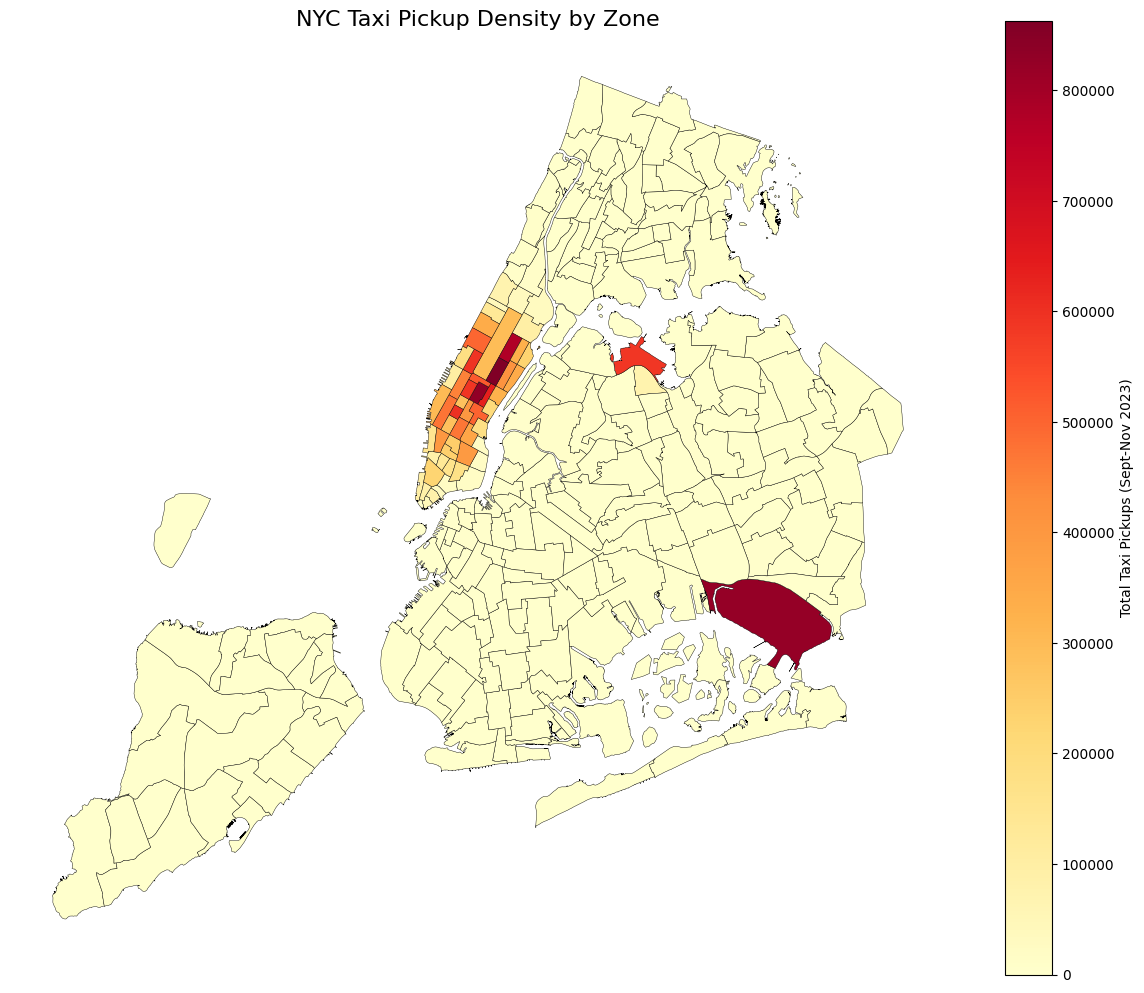

 Heatmap saved as: nyc_taxi_heatmap.png


In [ ]:
# Create static heatmap with geopandas
import geopandas as gpd

print("=" * 70)
print("CREATING STATIC HEATMAP")
print("=" * 70)

# Load shapefile
print("Loading taxi zone shapefile...")
zones_gdf = gpd.read_file("taxi_zones/taxi_zones.shp")
print(f"Loaded {len(zones_gdf)} taxi zones")
print("Shapefile columns:", zones_gdf.columns.tolist())

# Aggregate total trips by zone (from Spark)
total_trips_by_zone = df_clean.groupBy("PULocationID").agg(
    F.count("*").alias("total_trips")
).toPandas()
total_trips_by_zone.columns = ['LocationID', 'total_trips']

# Merge with shapefile
zones_gdf = zones_gdf.merge(
    total_trips_by_zone,
    on='LocationID',
    how='left'
)
zones_gdf['total_trips'] = zones_gdf['total_trips'].fillna(0)

# Create heatmap
print("\nCreating heatmap...")
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

zones_gdf.plot(
    column='total_trips',
    cmap='YlOrRd',
    legend=True,
    ax=ax,
    edgecolor='black',
    linewidth=0.3,
    legend_kwds={'label': "Total Taxi Pickups (Sept-Nov 2023)"}
)

ax.set_title('NYC Taxi Pickup Density by Zone', fontsize=16)
ax.axis('off')

plt.tight_layout()
plt.savefig('nyc_taxi_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Heatmap saved as: nyc_taxi_heatmap.png")

Creating improved heatmap with log scale comparison...


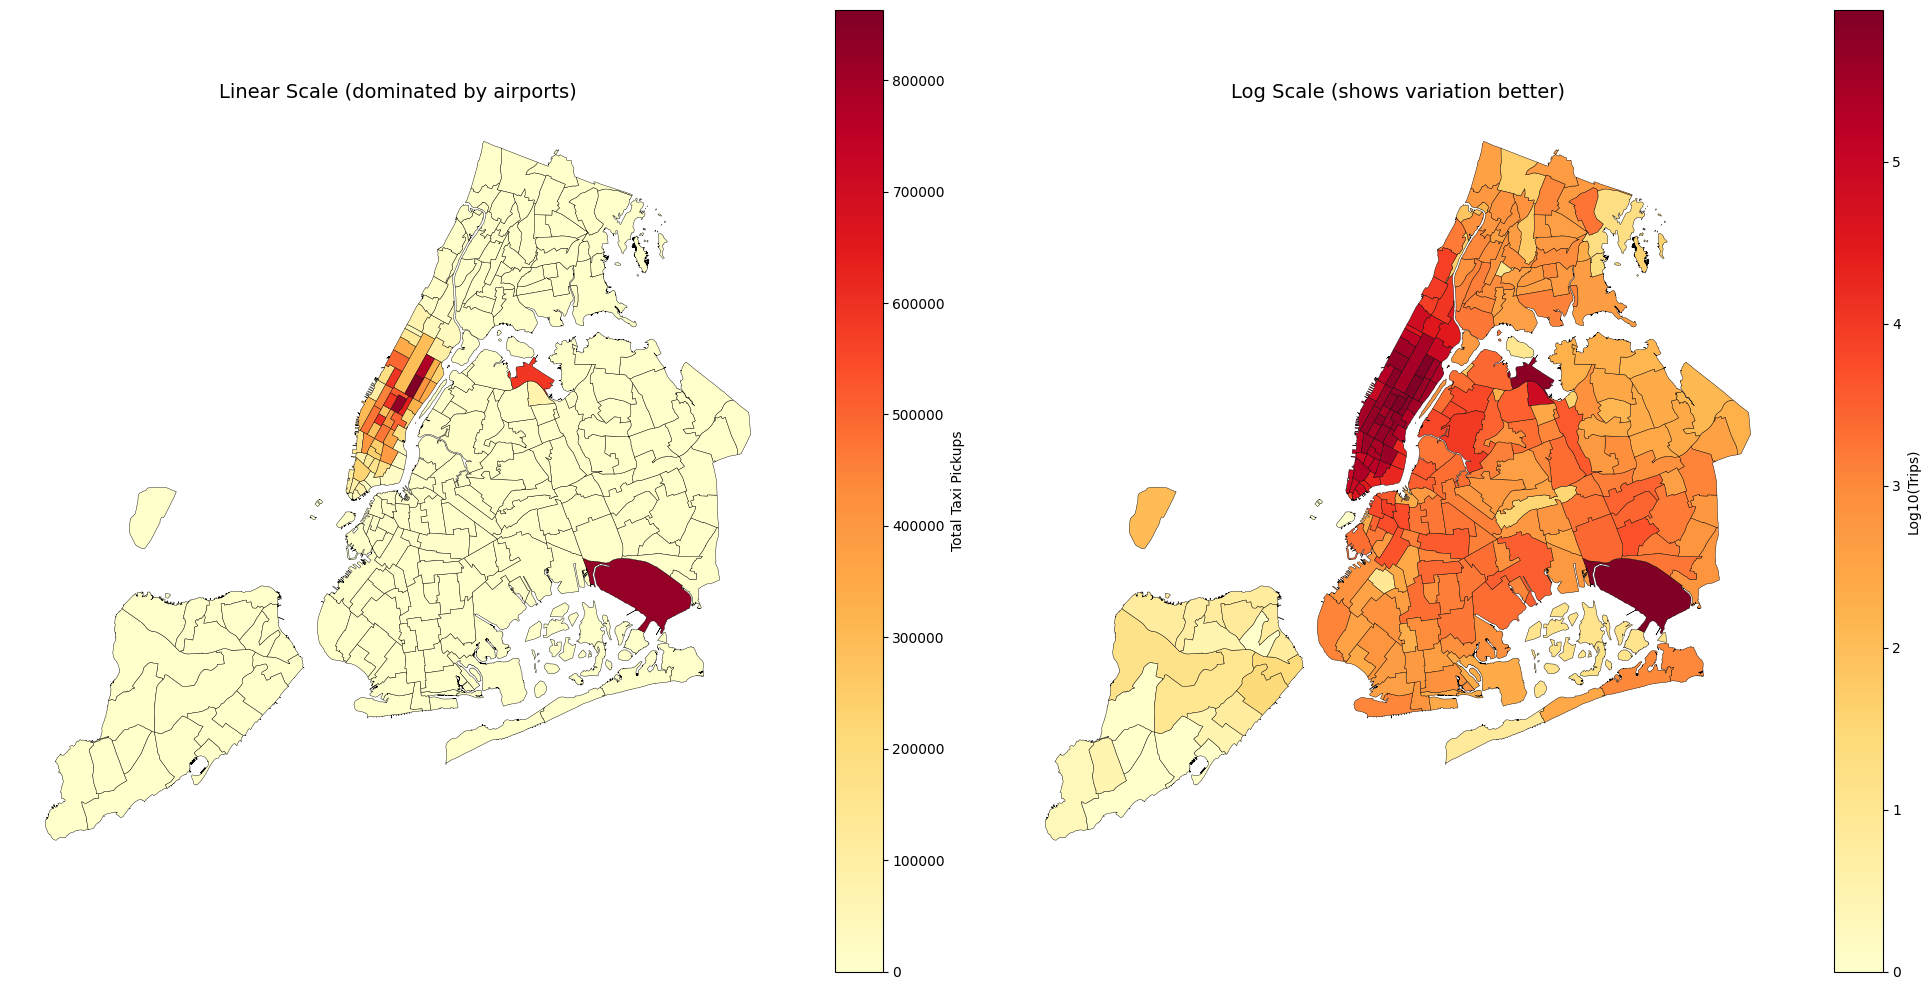


Top 10 zones by trip count:
                        zone   borough  total_trips
       Upper East Side South Manhattan     863065.0
              Midtown Center Manhattan     830857.0
                 JFK Airport    Queens     825226.0
       Upper East Side North Manhattan     778320.0
                Midtown East Manhattan     635022.0
Penn Station/Madison Sq West Manhattan     602971.0
         Lincoln Square East Manhattan     594592.0
   Times Sq/Theatre District Manhattan     590200.0
           LaGuardia Airport    Queens     588366.0
               Midtown North Manhattan     521841.0

Bottom 10 zones (excluding zero):
                               zone       borough  total_trips
             Charleston/Tottenville Staten Island          1.0
                            Oakwood Staten Island          2.0
                  Rossville/Woodrow Staten Island          2.0
                        Westerleigh Staten Island          2.0
                      Port Richmond Staten Island

In [ ]:
# Log scale vs Linear scale heatmap comparison
import numpy as np

print("Creating improved heatmap with log scale comparison...")

# Reload shapefile to avoid column conflicts
zones_gdf = gpd.read_file("taxi_zones/taxi_zones.shp")
zones_gdf = zones_gdf.merge(total_trips_by_zone, on='LocationID', how='left')
zones_gdf['total_trips'] = zones_gdf['total_trips'].fillna(0)

# Use log scale to better show variation
zones_gdf['log_trips'] = np.log10(zones_gdf['total_trips'] + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Left plot: Linear scale
zones_gdf.plot(
    column='total_trips',
    cmap='YlOrRd',
    legend=True,
    ax=ax1,
    edgecolor='black',
    linewidth=0.3,
    legend_kwds={'label': "Total Taxi Pickups"}
)
ax1.set_title('Linear Scale (dominated by airports)', fontsize=14)
ax1.axis('off')

# Right plot: Log scale
zones_gdf.plot(
    column='log_trips',
    cmap='YlOrRd',
    legend=True,
    ax=ax2,
    edgecolor='black',
    linewidth=0.3,
    legend_kwds={'label': "Log10(Trips)"}
)
ax2.set_title('Log Scale (shows variation better)', fontsize=14)
ax2.axis('off')

plt.tight_layout()
plt.savefig('nyc_taxi_heatmap_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Show top and bottom zones
print("\nTop 10 zones by trip count:")
top_10 = zones_gdf.nlargest(10, 'total_trips')[['zone', 'borough', 'total_trips']]
print(top_10.to_string(index=False))

print("\nBottom 10 zones (excluding zero):")
bottom_10 = zones_gdf[zones_gdf['total_trips'] > 0].nsmallest(10, 'total_trips')[['zone', 'borough', 'total_trips']]
print(bottom_10.to_string(index=False))

In [ ]:
# Create Folium interactive heatmap
import folium

print("Creating interactive heatmap...")

# Convert to WGS84 for Folium
zones_gdf_wgs84 = zones_gdf.to_crs(epsg=4326)

# NYC center coordinates
nyc_center = [40.7128, -74.0060]

# Create map
m = folium.Map(location=nyc_center, zoom_start=11, tiles='CartoDB positron')

# Add choropleth layer
folium.Choropleth(
    geo_data=zones_gdf_wgs84,
    name='choropleth',
    data=total_trips_by_zone,
    columns=['LocationID', 'total_trips'],
    key_on='feature.properties.LocationID',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Total Taxi Pickups (Sept-Nov 2023)'
).add_to(m)

folium.LayerControl().add_to(m)

# Save map
m.save('nyc_taxi_interactive_heatmap.html')
print(" Interactive map saved as: nyc_taxi_interactive_heatmap.html")
print("   Open this file in your browser to explore the map")

Creating interactive heatmap...
 Interactive map saved as: nyc_taxi_interactive_heatmap.html
   Open this file in your browser to explore the map


In [ ]:
# Top zones by borough analysis
print("=" * 70)
print("TOP ZONES BY BOROUGH")
print("=" * 70)

# Merge zones with borough info
zones_with_borough = zones_gdf.merge(
    zone_lookup[['LocationID', 'Zone', 'Borough']],
    on='LocationID',
    how='left'
)

# Get top zones for each borough
boroughs = ['Manhattan', 'Queens', 'Brooklyn', 'Bronx', 'Staten Island', 'EWR']

for borough in boroughs:
    print(f"\n{borough.upper()}")
    print("-" * 70)

    borough_zones = zones_with_borough[zones_with_borough['Borough'] == borough]

    if len(borough_zones) == 0:
        print(f"  No zones found in {borough}")
        continue

    top_zones = borough_zones.nlargest(10, 'total_trips')[['Zone', 'total_trips']]
    total_borough_trips = borough_zones['total_trips'].sum()

    print(f"Total trips in {borough}: {total_borough_trips:,}")
    print(f"\nTop 10 zones:")

    for idx, (zone_name, trips) in enumerate(top_zones.values, 1):
        pct = (trips / total_borough_trips) * 100 if total_borough_trips > 0 else 0
        print(f"  {idx:2d}. {zone_name:40s} {trips:>10,.0f} ({pct:5.2f}%)")

# Borough summary
print("\n" + "=" * 70)
print("BOROUGH SUMMARY")
print("=" * 70)

borough_summary = zones_with_borough.groupby('Borough')['total_trips'].agg(['sum', 'mean', 'count'])
borough_summary.columns = ['total_trips', 'avg_per_zone', 'num_zones']
borough_summary['pct_of_total'] = (borough_summary['total_trips'] / borough_summary['total_trips'].sum()) * 100
borough_summary = borough_summary.sort_values('total_trips', ascending=False)

print(f"\n{'Borough':<20} {'Total Trips':>12} {'Avg/Zone':>12} {'Zones':>8} {'% of Total':>10}")
print("-" * 70)
for borough, row in borough_summary.iterrows():
    print(f"{borough:<20} {row['total_trips']:>12,.0f} {row['avg_per_zone']:>12,.0f} {row['num_zones']:>8.0f} {row['pct_of_total']:>9.2f}%")

TOP ZONES BY BOROUGH

MANHATTAN
----------------------------------------------------------------------
Total trips in Manhattan: 15,476,253.0

Top 10 zones:
   1. Upper East Side South                       863,065 ( 5.58%)
   2. Midtown Center                              830,857 ( 5.37%)
   3. Upper East Side North                       778,320 ( 5.03%)
   4. Midtown East                                635,022 ( 4.10%)
   5. Penn Station/Madison Sq West                602,971 ( 3.90%)
   6. Lincoln Square East                         594,592 ( 3.84%)
   7. Times Sq/Theatre District                   590,200 ( 3.81%)
   8. Midtown North                               521,841 ( 3.37%)
   9. Murray Hill                                 504,068 ( 3.26%)
  10. Upper West Side South                       497,142 ( 3.21%)

QUEENS
----------------------------------------------------------------------
Total trips in Queens: 1,583,248.0

Top 10 zones:
   1. JFK Airport                           

In [ ]:
# Top 20 routes (Origin-Destination pairs)
print("=" * 70)
print("TOP 20 ROUTES ANALYSIS")
print("=" * 70)

# Aggregate routes from Spark
top_routes = df_clean.groupBy("PULocationID", "DOLocationID").agg(
    F.count("*").alias("trip_count")
).orderBy(F.desc("trip_count")).limit(20).toPandas()

# Merge with zone names for pickup
top_routes = top_routes.merge(
    zone_lookup[['LocationID', 'Zone']],
    left_on='PULocationID',
    right_on='LocationID',
    how='left'
)
top_routes = top_routes.rename(columns={'Zone': 'Pickup_Zone'})
top_routes = top_routes.drop('LocationID', axis=1)

# Merge with zone names for dropoff
top_routes = top_routes.merge(
    zone_lookup[['LocationID', 'Zone']],
    left_on='DOLocationID',
    right_on='LocationID',
    how='left'
)
top_routes = top_routes.rename(columns={'Zone': 'Dropoff_Zone'})
top_routes = top_routes.drop('LocationID', axis=1)

# Fill NaN values
top_routes['Pickup_Zone'] = top_routes['Pickup_Zone'].fillna('Unknown Zone')
top_routes['Dropoff_Zone'] = top_routes['Dropoff_Zone'].fillna('Unknown Zone')

print("\nTop 20 Routes:")
print("-" * 100)
for idx, row in top_routes.iterrows():
    pickup = str(row['Pickup_Zone'])[:35].ljust(35)
    dropoff = str(row['Dropoff_Zone'])[:35].ljust(35)
    count = f"{row['trip_count']:,}".rjust(10)
    print(f"{pickup} → {dropoff} {count} trips")

TOP 20 ROUTES ANALYSIS

Top 20 Routes:
----------------------------------------------------------------------------------------------------
Upper East Side South               → Upper East Side North                  132,308 trips
Upper East Side North               → Upper East Side South                  114,903 trips
Upper East Side South               → Upper East Side South                   86,728 trips
Upper East Side North               → Upper East Side North                   86,347 trips
Midtown Center                      → Upper East Side South                   61,030 trips
Upper East Side South               → Midtown Center                          56,422 trips
Midtown Center                      → Upper East Side North                   50,945 trips
Lincoln Square East                 → Upper West Side South                   50,398 trips
Upper West Side South               → Lincoln Square East                     48,430 trips
Upper West Side South               → Upp

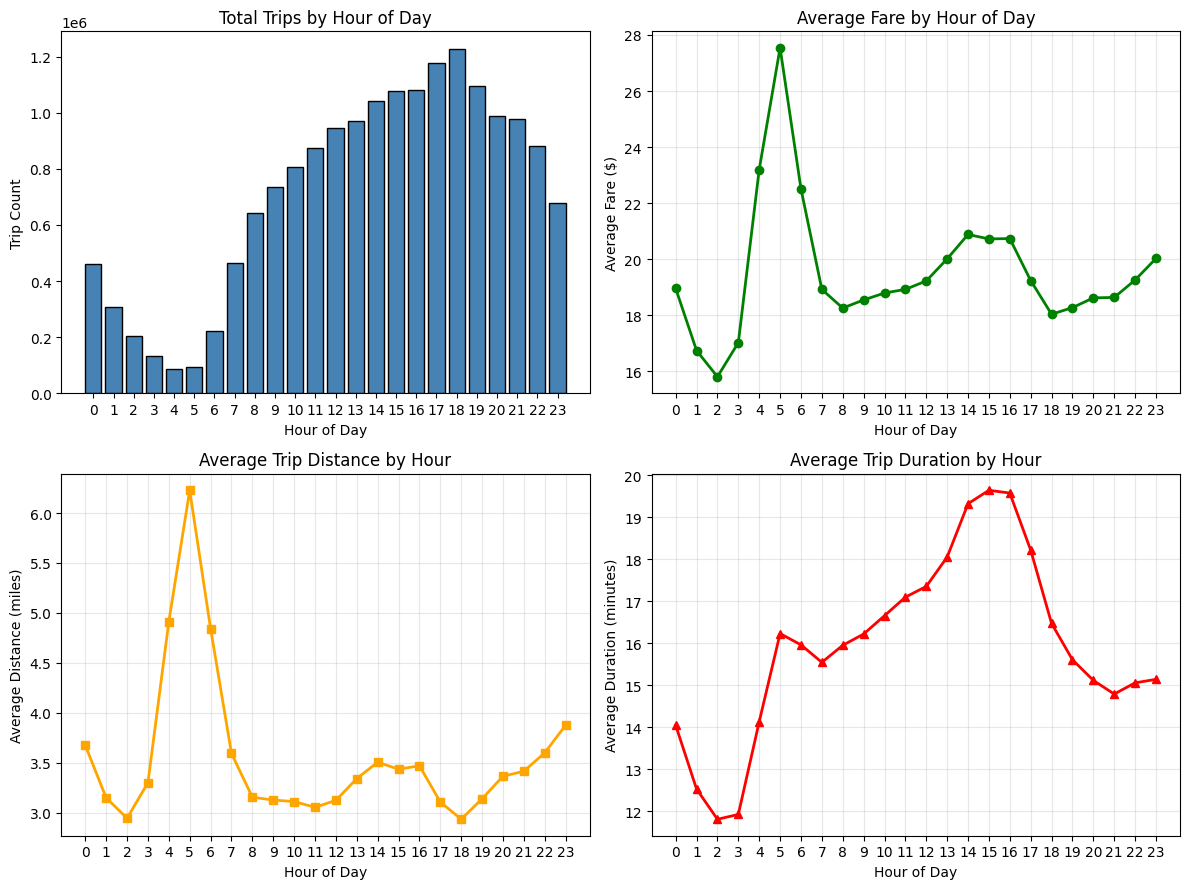

 Hourly analysis plots saved


In [ ]:
# Extract temporal features for EDA
df_eda = df_clean.withColumn("pickup_hour", F.hour("tpep_pickup_datetime")) \
    .withColumn("pickup_day", F.dayofweek("tpep_pickup_datetime")) \
    .withColumn("pickup_date", F.to_date("tpep_pickup_datetime")) \
    .withColumn("pickup_month", F.month("tpep_pickup_datetime"))

# Hourly distribution analysis
hourly_trips = df_eda.groupBy("pickup_hour").agg(
    F.count("*").alias("trip_count"),
    F.avg("fare_amount").alias("avg_fare"),
    F.avg("trip_distance").alias("avg_distance"),
    F.avg("trip_duration_minutes").alias("avg_duration")
).orderBy("pickup_hour")

hourly_pd = hourly_trips.toPandas()

# Plot hourly distribution
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

# Trip count by hour
axes[0, 0].bar(hourly_pd['pickup_hour'], hourly_pd['trip_count'], color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Trip Count')
axes[0, 0].set_title('Total Trips by Hour of Day')
axes[0, 0].set_xticks(range(0, 24))

# Average fare by hour
axes[0, 1].plot(hourly_pd['pickup_hour'], hourly_pd['avg_fare'], marker='o', color='green', linewidth=2)
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].set_ylabel('Average Fare ($)')
axes[0, 1].set_title('Average Fare by Hour of Day')
axes[0, 1].set_xticks(range(0, 24))
axes[0, 1].grid(True, alpha=0.3)

# Average distance by hour
axes[1, 0].plot(hourly_pd['pickup_hour'], hourly_pd['avg_distance'], marker='s', color='orange', linewidth=2)
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Average Distance (miles)')
axes[1, 0].set_title('Average Trip Distance by Hour')
axes[1, 0].set_xticks(range(0, 24))
axes[1, 0].grid(True, alpha=0.3)

# Average duration by hour
axes[1, 1].plot(hourly_pd['pickup_hour'], hourly_pd['avg_duration'], marker='^', color='red', linewidth=2)
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Average Duration (minutes)')
axes[1, 1].set_title('Average Trip Duration by Hour')
axes[1, 1].set_xticks(range(0, 24))
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hourly_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Hourly analysis plots saved")

WEEKDAY VS WEEKEND PATTERNS


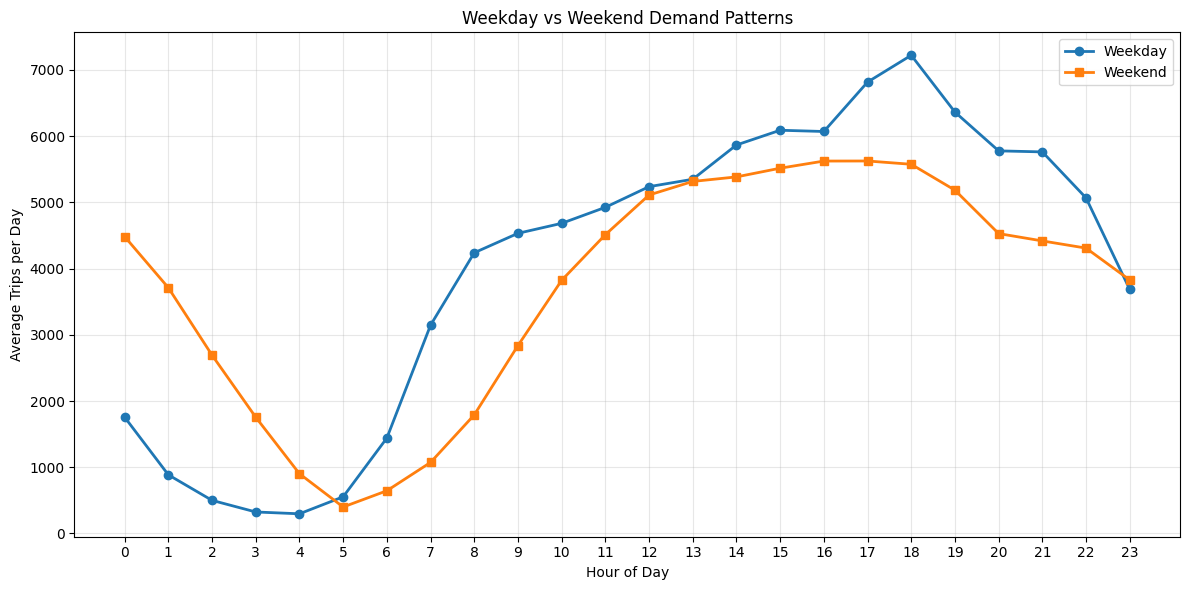

Saved weekday_vs_weekend.png


In [ ]:
# Weekday vs Weekend hourly patterns
print("=" * 70)
print("WEEKDAY VS WEEKEND PATTERNS")
print("=" * 70)

# Add day of week and weekend flag to Spark DF
df_temporal = df_clean.withColumn("hour_of_day", F.hour("tpep_pickup_datetime")) \
    .withColumn("day_of_week", F.dayofweek("tpep_pickup_datetime")) \
    .withColumn("is_weekend", F.when(F.col("day_of_week").isin([1, 7]), 1).otherwise(0))

# Aggregate by hour and weekend flag
hourly_pattern = df_temporal.groupBy("hour_of_day", "is_weekend").agg(
    F.count("*").alias("trip_count")
).toPandas()

# Separate weekday and weekend
weekday_hourly = hourly_pattern[hourly_pattern['is_weekend'] == 0].sort_values('hour_of_day')
weekend_hourly = hourly_pattern[hourly_pattern['is_weekend'] == 1].sort_values('hour_of_day')

# Normalize by number of days (weekdays ~130 days, weekends ~52 days in 6 months)
weekday_hourly['avg_trips'] = weekday_hourly['trip_count'] / 130
weekend_hourly['avg_trips'] = weekend_hourly['trip_count'] / 52

# Plot
plt.figure(figsize=(12, 6))
plt.plot(weekday_hourly['hour_of_day'], weekday_hourly['avg_trips'],
         label='Weekday', linewidth=2, marker='o')
plt.plot(weekend_hourly['hour_of_day'], weekend_hourly['avg_trips'],
         label='Weekend', linewidth=2, marker='s')
plt.xlabel('Hour of Day')
plt.ylabel('Average Trips per Day')
plt.title('Weekday vs Weekend Demand Patterns')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.savefig('weekday_vs_weekend.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved weekday_vs_weekend.png")

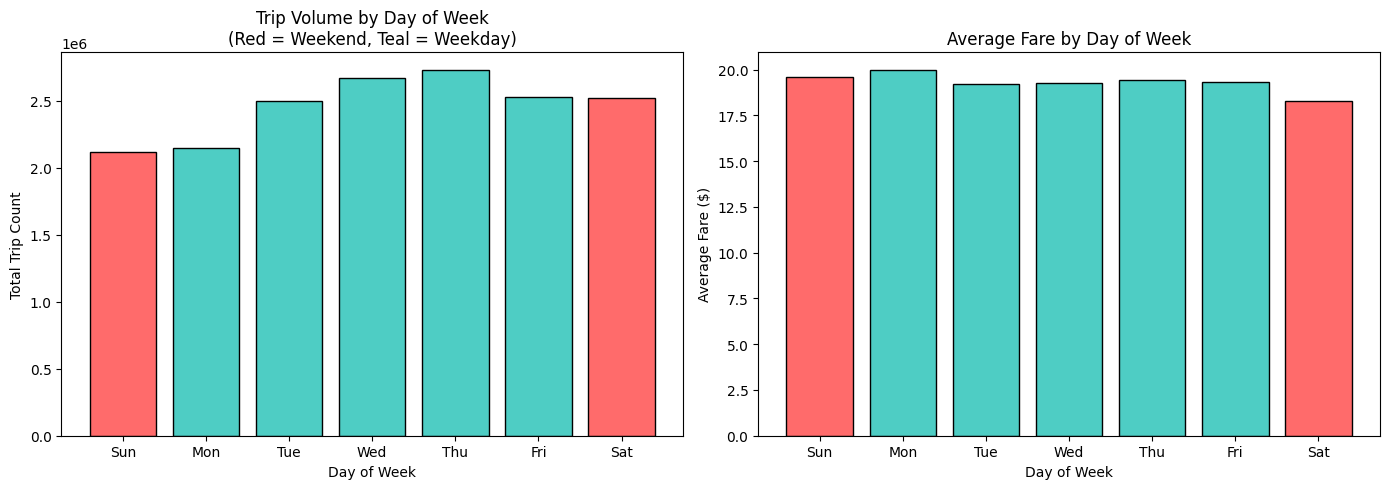

In [ ]:
# Day of week analysis
day_names = {1: 'Sun', 2: 'Mon', 3: 'Tue', 4: 'Wed', 5: 'Thu', 6: 'Fri', 7: 'Sat'}

daily_trips = df_eda.groupBy("pickup_day").agg(
    F.count("*").alias("trip_count"),
    F.avg("fare_amount").alias("avg_fare"),
    F.avg("trip_distance").alias("avg_distance")
).orderBy("pickup_day")

daily_pd = daily_trips.toPandas()
daily_pd['day_name'] = daily_pd['pickup_day'].map(day_names)

# Plot day of week distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['#FF6B6B' if d in [1, 7] else '#4ECDC4' for d in daily_pd['pickup_day']]

axes[0].bar(daily_pd['day_name'], daily_pd['trip_count'], color=colors, edgecolor='black')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Total Trip Count')
axes[0].set_title('Trip Volume by Day of Week\n(Red = Weekend, Teal = Weekday)')

axes[1].bar(daily_pd['day_name'], daily_pd['avg_fare'], color=colors, edgecolor='black')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Average Fare ($)')
axes[1].set_title('Average Fare by Day of Week')

plt.tight_layout()
plt.savefig('daily_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Payment type analysis
print("=" * 70)
print("PAYMENT TYPE ANALYSIS")
print("=" * 70)

# Aggregate payment by hour
payment_by_hour = df_clean.withColumn("hour_of_day", F.hour("tpep_pickup_datetime")) \
    .groupBy("hour_of_day", "payment_type").agg(
        F.count("*").alias("trip_count")
    ).toPandas()

payment_pivot = payment_by_hour.pivot(index='hour_of_day', columns='payment_type', values='trip_count').fillna(0)

payment_labels = {1: 'Credit Card', 2: 'Cash', 3: 'No Charge', 4: 'Dispute', 0: 'Unknown'}
payment_pivot.columns = [payment_labels.get(col, f'Type {col}') for col in payment_pivot.columns]

payment_pct = payment_pivot.div(payment_pivot.sum(axis=1), axis=0) * 100

print("\nOverall Payment Distribution:")
payment_totals = df_clean.groupBy("payment_type").agg(F.count("*").alias("trips")).toPandas()
total_trips = payment_totals['trips'].sum()
for _, row in payment_totals.sort_values('trips', ascending=False).iterrows():
    ptype = payment_labels.get(row['payment_type'], f"Type {row['payment_type']}")
    pct = (row['trips'] / total_trips) * 100
    print(f"  {ptype}: {row['trips']:,} trips ({pct:.2f}%)")

PAYMENT TYPE ANALYSIS

Overall Payment Distribution:
  Credit Card: 14,300,907 trips (83.22%)
  Cash: 2,700,730 trips (15.72%)
  Dispute: 128,282 trips (0.75%)
  No Charge: 55,071 trips (0.32%)


PASSENGER COUNT ANALYSIS


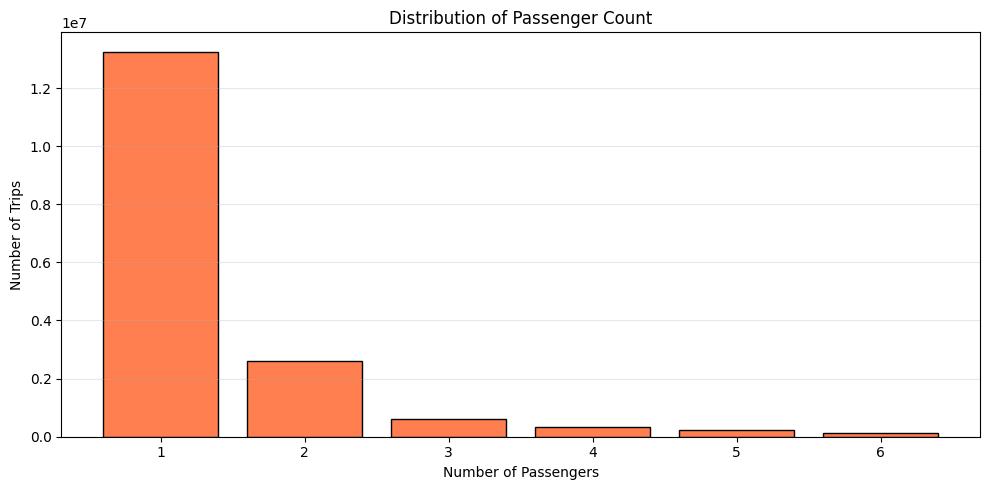


Passenger Count Statistics:
  1 passenger(s): 13,254,892 trips (77.13%)
  2 passenger(s):  2,610,255 trips (15.19%)
  3 passenger(s):    611,693 trips ( 3.56%)
  4 passenger(s):    349,103 trips ( 2.03%)
  5 passenger(s):    218,471 trips ( 1.27%)
  6 passenger(s):    140,576 trips ( 0.82%)


In [ ]:
# Passenger count distribution
print("=" * 70)
print("PASSENGER COUNT ANALYSIS")
print("=" * 70)

# Aggregate passenger counts
passenger_counts = df_clean.groupBy("passenger_count").agg(
    F.count("*").alias("trip_count")
).orderBy("passenger_count").toPandas()

# Plot
plt.figure(figsize=(10, 5))
plt.bar(passenger_counts['passenger_count'], passenger_counts['trip_count'],
        color='coral', edgecolor='black')
plt.xlabel('Number of Passengers')
plt.ylabel('Number of Trips')
plt.title('Distribution of Passenger Count')
plt.xticks(range(1, 7))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('passenger_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistics
print("\nPassenger Count Statistics:")
total_trips = passenger_counts['trip_count'].sum()
for _, row in passenger_counts.iterrows():
    pct = (row['trip_count'] / total_trips) * 100
    print(f"  {int(row['passenger_count'])} passenger(s): {row['trip_count']:>10,} trips ({pct:5.2f}%)")

TRIP CHARACTERISTICS ANALYSIS


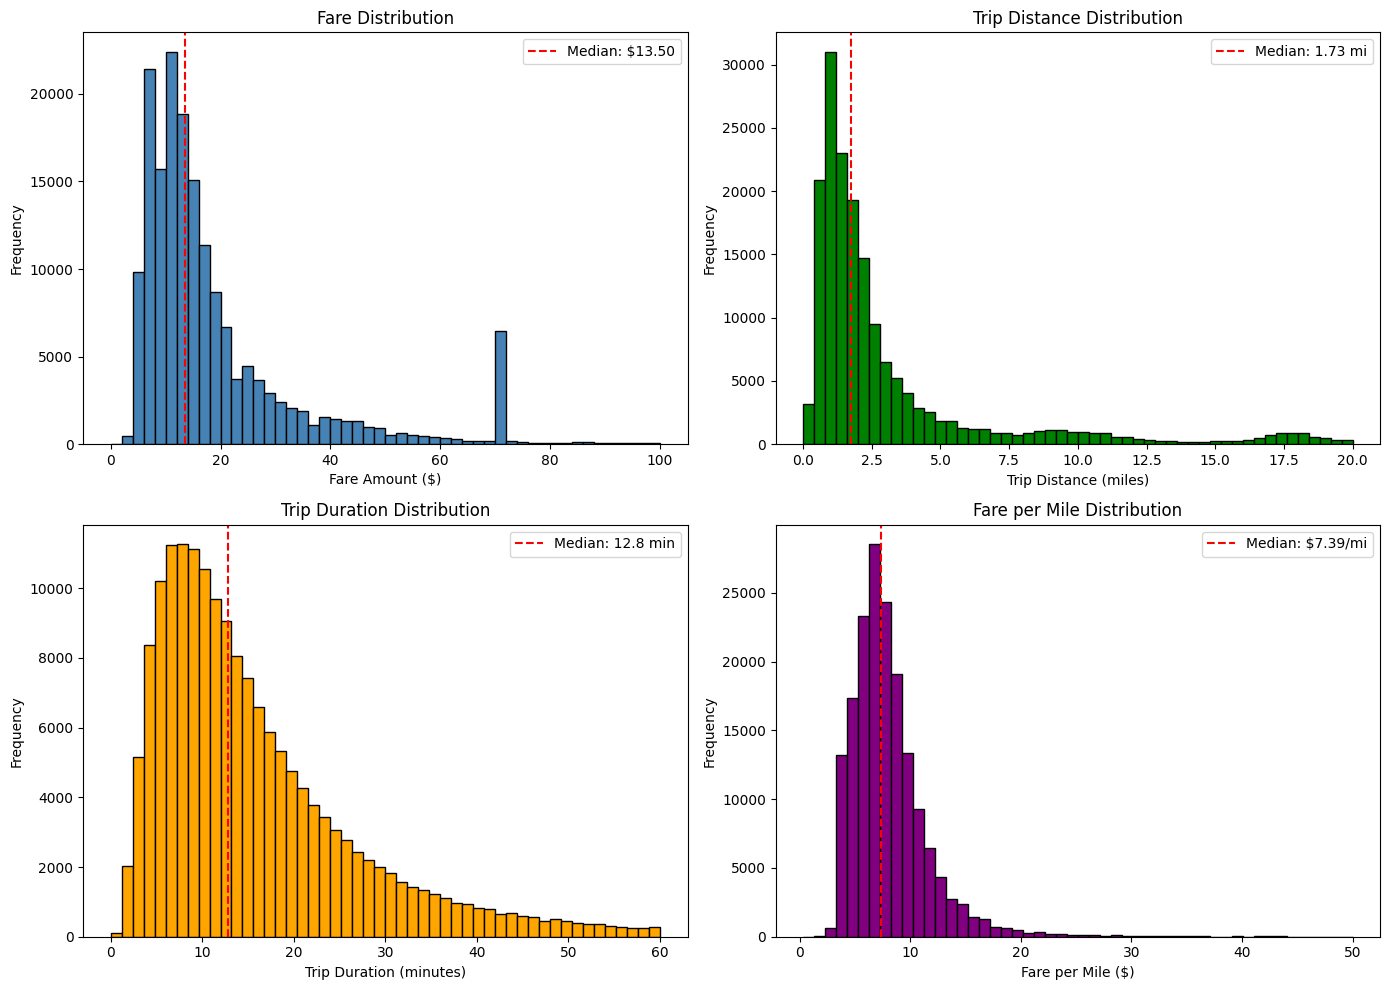

Saved trip_characteristics.png


In [ ]:
# Trip characteristics 4-panel plot
print("=" * 70)
print("TRIP CHARACTERISTICS ANALYSIS")
print("=" * 70)

# Sample data for histograms (1% sample to keep it fast)
sample_df = df_clean.sample(fraction=0.01).toPandas()

# Calculate fare per mile
sample_df['fare_per_mile'] = sample_df['fare_amount'] / sample_df['trip_distance']
sample_df_valid = sample_df[sample_df['fare_per_mile'] < 50]  # Remove outliers

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Fare distribution
axes[0, 0].hist(sample_df['fare_amount'], bins=50, edgecolor='black', range=(0, 100), color='steelblue')
axes[0, 0].set_xlabel('Fare Amount ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Fare Distribution')
median_fare = sample_df['fare_amount'].median()
axes[0, 0].axvline(median_fare, color='red', linestyle='--', label=f'Median: ${median_fare:.2f}')
axes[0, 0].legend()

# Distance distribution
axes[0, 1].hist(sample_df['trip_distance'], bins=50, edgecolor='black', range=(0, 20), color='green')
axes[0, 1].set_xlabel('Trip Distance (miles)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Trip Distance Distribution')
median_dist = sample_df['trip_distance'].median()
axes[0, 1].axvline(median_dist, color='red', linestyle='--', label=f'Median: {median_dist:.2f} mi')
axes[0, 1].legend()

# Duration distribution
axes[1, 0].hist(sample_df['trip_duration_minutes'], bins=50, edgecolor='black', range=(0, 60), color='orange')
axes[1, 0].set_xlabel('Trip Duration (minutes)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Trip Duration Distribution')
median_dur = sample_df['trip_duration_minutes'].median()
axes[1, 0].axvline(median_dur, color='red', linestyle='--', label=f'Median: {median_dur:.1f} min')
axes[1, 0].legend()

# Fare per mile distribution
axes[1, 1].hist(sample_df_valid['fare_per_mile'], bins=50, edgecolor='black', color='purple')
axes[1, 1].set_xlabel('Fare per Mile ($)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Fare per Mile Distribution')
median_fpm = sample_df_valid['fare_per_mile'].median()
axes[1, 1].axvline(median_fpm, color='red', linestyle='--', label=f'Median: ${median_fpm:.2f}/mi')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('trip_characteristics.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved trip_characteristics.png")

In [ ]:
# Top pickup zones analysis
top_pickup_zones = df_clean.groupBy("PULocationID").agg(
    F.count("*").alias("trip_count"),
    F.avg("fare_amount").alias("avg_fare"),
    F.sum("fare_amount").alias("total_revenue")
).orderBy(F.desc("trip_count")).limit(20)

# Join with zone names
top_zones_with_names = top_pickup_zones.join(
    zones_df.select("LocationID", "Zone", "Borough"),
    top_pickup_zones["PULocationID"] == zones_df["LocationID"],
    "left"
)

print("\n Top 20 Pickup Zones by Trip Volume:")
top_zones_with_names.select(
    "Zone", "Borough", "trip_count", "avg_fare", "total_revenue"
).show(20, truncate=False)


 Top 20 Pickup Zones by Trip Volume:
+----------------------------+---------+----------+------------------+--------------------+
|Zone                        |Borough  |trip_count|avg_fare          |total_revenue       |
+----------------------------+---------+----------+------------------+--------------------+
|Upper East Side South       |Manhattan|863065    |13.205793260067377|1.1397457960000051E7|
|Midtown Center              |Manhattan|830857    |16.851132782175565|1.4000881630000044E7|
|JFK Airport                 |Queens   |825226    |62.199011955512226|5.1328241839999534E7|
|Upper East Side North       |Manhattan|778320    |13.425067363038485|1.0448998430000113E7|
|Midtown East                |Manhattan|635022    |16.194087023756705|1.028360153000003E7 |
|Penn Station/Madison Sq West|Manhattan|602971    |17.36907081766784 |1.0473045999999994E7|
|Lincoln Square East         |Manhattan|594592    |14.292209767369869|8498033.589999985   |
|Times Sq/Theatre District   |Manhattan|59

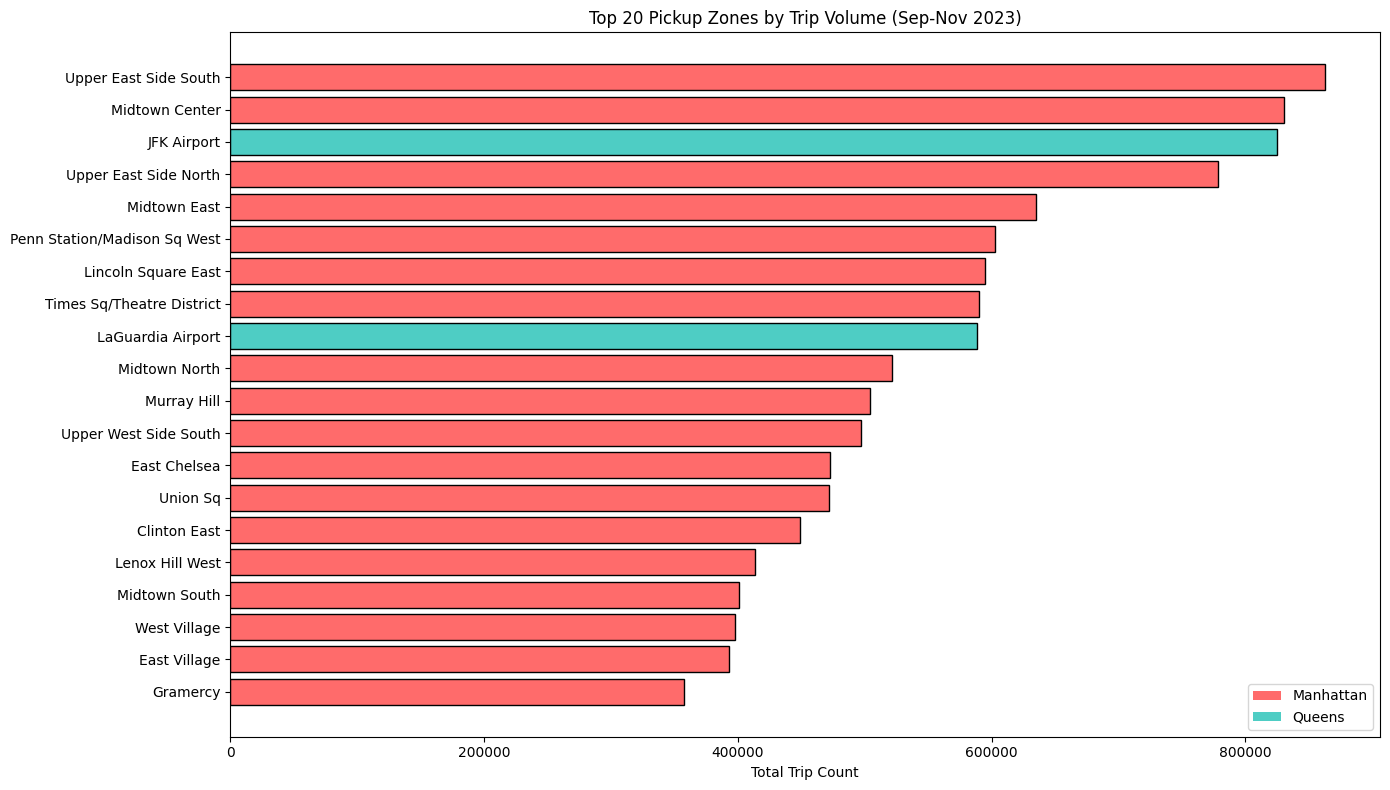

In [ ]:
# Visualize top zones
top_zones_pd = top_zones_with_names.toPandas()

fig, ax = plt.subplots(figsize=(14, 8))

# Color by borough
borough_colors = {
    'Manhattan': '#FF6B6B',
    'Queens': '#4ECDC4',
    'Brooklyn': '#45B7D1',
    'Bronx': '#96CEB4',
    'Staten Island': '#FFEAA7',
    'EWR': '#DDA0DD'
}

colors = [borough_colors.get(b, '#CCCCCC') for b in top_zones_pd['Borough']]

bars = ax.barh(top_zones_pd['Zone'], top_zones_pd['trip_count'], color=colors, edgecolor='black')
ax.set_xlabel('Total Trip Count')
ax.set_title('Top 20 Pickup Zones by Trip Volume (Sep-Nov 2023)')
ax.invert_yaxis()

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=borough) for borough, color in borough_colors.items() if borough in top_zones_pd['Borough'].values]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('top_zones.png', dpi=150, bbox_inches='tight')
plt.show()

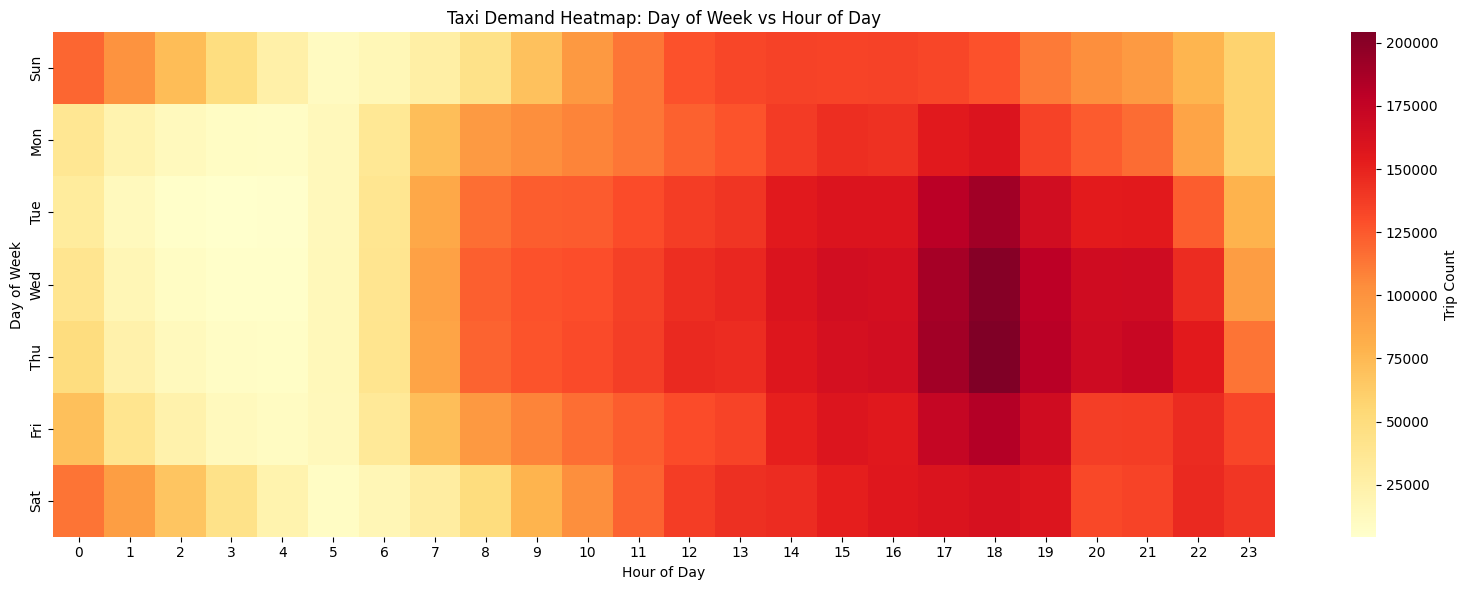

In [ ]:
# Heatmap: Hour vs Day of Week
heatmap_data = df_eda.groupBy("pickup_day", "pickup_hour").agg(
    F.count("*").alias("trip_count")
).toPandas()

# Pivot for heatmap
heatmap_pivot = heatmap_data.pivot(index='pickup_day', columns='pickup_hour', values='trip_count')
heatmap_pivot.index = [day_names[i] for i in heatmap_pivot.index]

plt.figure(figsize=(16, 6))
sns.heatmap(heatmap_pivot, cmap='YlOrRd', annot=False, fmt='.0f',
            cbar_kws={'label': 'Trip Count'})
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.title('Taxi Demand Heatmap: Day of Week vs Hour of Day')
plt.tight_layout()
plt.savefig('demand_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

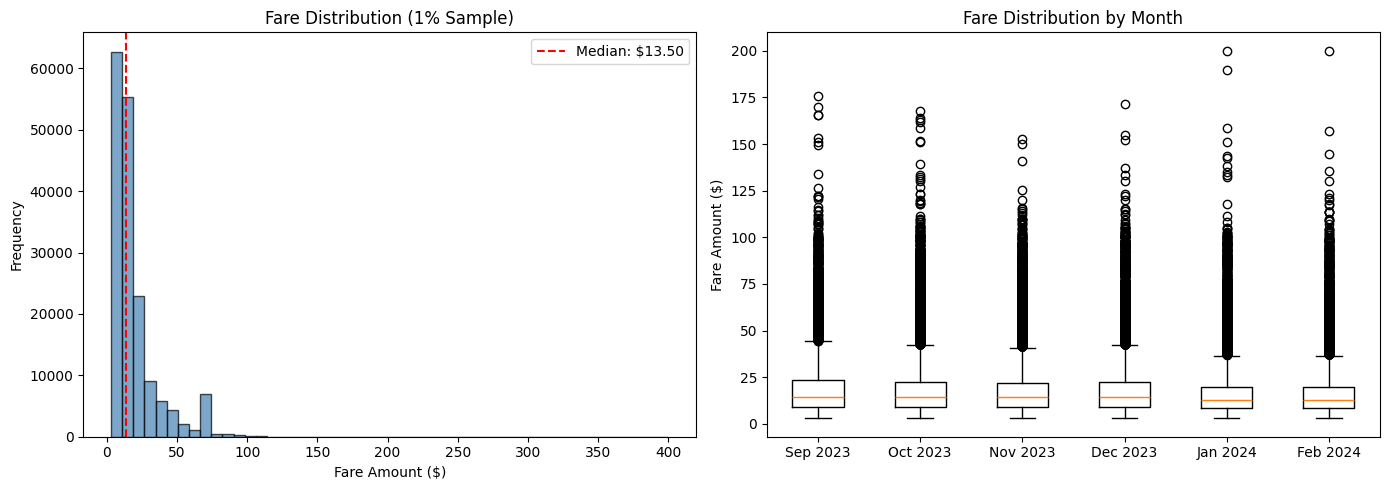

In [ ]:
# Fare distribution analysis
fare_sample = df_clean.select("fare_amount").sample(0.01).toPandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(fare_sample['fare_amount'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Fare Amount ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Fare Distribution (1% Sample)')
axes[0].axvline(fare_sample['fare_amount'].median(), color='red', linestyle='--', label=f'Median: ${fare_sample["fare_amount"].median():.2f}')
axes[0].legend()

# Box plot by month
df_sample = df_eda.select("fare_amount", "pickup_month").sample(0.01).toPandas()
axes[1].boxplot(
    [df_sample[df_sample['pickup_month']==m]['fare_amount'] for m in [9, 10, 11, 12, 1, 2]],
    labels=['Sep 2023', 'Oct 2023', 'Nov 2023', 'Dec 2023', 'Jan 2024', 'Feb 2024']
)
axes[1].set_ylabel('Fare Amount ($)')
axes[1].set_title('Fare Distribution by Month')

plt.tight_layout()
plt.savefig('fare_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Comprehensive summary report
print("=" * 70)
print("COMPREHENSIVE DATA ANALYSIS SUMMARY")
print("=" * 70)

# Get stats from Spark
total_trips = df_clean.count()
date_min = df_clean.agg(F.min("tpep_pickup_datetime")).collect()[0][0]
date_max = df_clean.agg(F.max("tpep_pickup_datetime")).collect()[0][0]
avg_fare = df_clean.agg(F.avg("fare_amount")).collect()[0][0]
median_fare = df_clean.approxQuantile("fare_amount", [0.5], 0.01)[0]
avg_distance = df_clean.agg(F.avg("trip_distance")).collect()[0][0]
avg_duration = df_clean.agg(F.avg("trip_duration_minutes")).collect()[0][0]

# Peak hour
peak_hour_df = df_clean.withColumn("hour", F.hour("tpep_pickup_datetime")) \
    .groupBy("hour").count().orderBy(F.desc("count")).first()
peak_hour = peak_hour_df['hour']

# Daily average
num_days = (date_max - date_min).days + 1
avg_daily_trips = total_trips / num_days

print(f"""
 Dataset Overview:
   Total trips: {total_trips:,}
   Date range: {date_min} to {date_max}
   Number of days: {num_days}

 Temporal Patterns:
   Peak hour: {peak_hour}:00
   Average trips per day: {avg_daily_trips:,.0f}

 Trip Statistics:
   Average fare: ${avg_fare:.2f}
   Median fare: ${median_fare:.2f}
   Average distance: {avg_distance:.2f} miles
   Average duration: {avg_duration:.1f} minutes

 Geographic Distribution:
""")

# Borough breakdown
for borough, row in borough_summary.iterrows():
    print(f"   {borough}: {row['total_trips']:,.0f} trips ({row['pct_of_total']:.1f}%)")

COMPREHENSIVE DATA ANALYSIS SUMMARY

 Dataset Overview:
   Total trips: 17,184,990
   Date range: 2023-09-01 00:00:00 to 2024-02-29 23:59:58
   Number of days: 182

 Temporal Patterns:
   Peak hour: 18:00
   Average trips per day: 94,423

 Trip Statistics:
   Average fare: $19.27
   Median fare: $13.50
   Average distance: 3.34 miles
   Average duration: 16.7 minutes

 Geographic Distribution:

   Manhattan: 15,476,253 trips (90.1%)
   Queens: 1,583,248 trips (9.2%)
   Brooklyn: 99,186 trips (0.6%)
   Bronx: 27,168 trips (0.2%)
   EWR: 114 trips (0.0%)
   Staten Island: 108 trips (0.0%)


---
## 5. Zone-Hour Aggregation <a name="5-zone-hour-aggregation"></a>

Aggregate the cleaned trip data to a zone–hour level by truncating pickup timestamps to the hour and grouping by `LocationID`. For each zone and hour, we compute total trips, fares, distances, and durations, creating a compact demand time series that serves as the foundation for weather integration, feature engineering, and modeling.


In [ ]:
print("=" * 70)
print("ZONE-HOUR AGGREGATION")
print("=" * 70)

# Create hourly timestamp (truncate to hour)
df_agg = df_clean.withColumn(
    "pickup_hour_ts",
    F.date_trunc("hour", "tpep_pickup_datetime")
)

# Aggregate by zone and hour
zone_hour_agg = df_agg.groupBy("PULocationID", "pickup_hour_ts").agg(
    # Demand metrics
    F.count("*").alias("trip_count"),
    F.sum("passenger_count").alias("total_passengers"),

    # Revenue metrics
    F.sum("fare_amount").alias("total_fare"),
    F.avg("fare_amount").alias("avg_fare"),
    F.sum("tip_amount").alias("total_tips"),
    F.avg("tip_amount").alias("avg_tip"),
    F.sum("total_amount").alias("total_revenue"),

    # Trip characteristics
    F.avg("trip_distance").alias("avg_distance"),
    F.avg("trip_duration_minutes").alias("avg_duration"),
    F.avg("speed_mph").alias("avg_speed"),

    # Statistical measures
    F.stddev("fare_amount").alias("fare_stddev"),
    F.min("fare_amount").alias("min_fare"),
    F.max("fare_amount").alias("max_fare")
)

# Rename columns for clarity
zone_hour_agg = zone_hour_agg.withColumnRenamed("PULocationID", "LocationID")

# Cache the aggregated data
zone_hour_agg = zone_hour_agg.cache()

agg_count = zone_hour_agg.count()
print(f"\n Zone-Hour Aggregation Complete")
print(f" Total Zone-Hour Records: {agg_count:,}")
print(f" Unique Zones: {zone_hour_agg.select('LocationID').distinct().count()}")
print(f" Time Range: {zone_hour_agg.agg(F.min('pickup_hour_ts')).collect()[0][0]} to {zone_hour_agg.agg(F.max('pickup_hour_ts')).collect()[0][0]}")

ZONE-HOUR AGGREGATION

 Zone-Hour Aggregation Complete
 Total Zone-Hour Records: 389,600
 Unique Zones: 255
 Time Range: 2023-09-01 00:00:00 to 2024-02-29 23:00:00


In [ ]:
# Show sample aggregated data
print("\n Sample Zone-Hour Aggregated Data:")
zone_hour_agg.orderBy(F.desc("trip_count")).show(10, truncate=False)


 Sample Zone-Hour Aggregated Data:
+----------+-------------------+----------+----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------+--------+
|LocationID|pickup_hour_ts     |trip_count|total_passengers|total_fare        |avg_fare          |total_tips        |avg_tip           |total_revenue     |avg_distance      |avg_duration      |avg_speed         |fare_stddev       |min_fare|max_fare|
+----------+-------------------+----------+----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------+--------+
|79        |2023-11-05 01:00:00|856       |1310            |12182.200000000006|14.231542056074774|2502.7599999999993|2.923785046728971 |18976.810000000012|2.405070093457944 |11.819781931464185|11.719130010432977|7.

In [ ]:
# Statistics of aggregated data
print("\n Aggregation Statistics:")
zone_hour_agg.select(
    "trip_count", "avg_fare", "avg_distance", "avg_duration", "total_revenue"
).describe().show()


 Aggregation Statistics:
+-------+-----------------+------------------+-----------------+------------------+------------------+
|summary|       trip_count|          avg_fare|     avg_distance|      avg_duration|     total_revenue|
+-------+-----------------+------------------+-----------------+------------------+------------------+
|  count|           389600|            389600|           389600|            389600|            389600|
|   mean|44.10931724845996| 23.69651448008668|4.511622268253854| 21.26622701451971|1255.5794165296636|
| stddev|74.27687017226015|15.501854093181896|4.034950135764961|17.298140865872497| 2754.276333310517|
|    min|                1|               3.0|             0.01|1.0166666666666666|               4.5|
|    max|              856|             500.0|            57.03|            179.95| 48730.09000000001|
+-------+-----------------+------------------+-----------------+------------------+------------------+



---
## 6. External Factors: Weather and Holidays <a name="6-weather-data-integration"></a>

In this section, we join hourly weather data to the zone–hour demand table and analyze how temperature, precipitation, snow, and wind relate to taxi usage. We also identify major holidays within the analysis period and compare demand on those days to typical days in the same month, highlighting how special events interact with normal temporal patterns.


In [ ]:
print("=" * 70)
print("WEATHER DATA INTEGRATION")
print("=" * 70)

# Fetch weather data using Meteostat
from meteostat import Point, Hourly
from datetime import datetime

# Central Park coordinates
nyc = Point(40.7829, -73.9654)

# Time range
start = datetime(2023, 9, 1)
end = datetime(2023, 11, 30, 23, 59)

# Fetch hourly weather data
weather_data = Hourly(nyc, start, end)
weather_df = weather_data.fetch()

print(f"\n Weather data fetched: {len(weather_df)} hourly records")
print("\n Weather Data Sample:")
weather_df.head()

WEATHER DATA INTEGRATION

 Weather data fetched: 2184 hourly records

 Weather Data Sample:


,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2023-09-01 00:00:00,21.0,7.6,42.0,0.0,<NA>,15.0,7.0,<NA>,1019.0,<NA>,1.0
2023-09-01 01:00:00,21.0,8.9,46.0,0.0,<NA>,15.0,9.0,<NA>,1019.0,<NA>,1.0
2023-09-01 02:00:00,20.0,8.3,47.0,0.0,<NA>,20.0,7.0,<NA>,1020.0,<NA>,1.0
2023-09-01 03:00:00,21.0,8.6,45.0,0.0,<NA>,50.0,15.0,<NA>,1021.0,<NA>,1.0
2023-09-01 04:00:00,19.0,7.4,47.0,0.0,<NA>,25.0,7.0,<NA>,1022.0,<NA>,1.0


In [ ]:
# Prepare weather data
weather_df = weather_df.reset_index()
weather_df.columns = ['weather_hour', 'temp_c', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'coco']

# Convert temperature to Fahrenheit
weather_df['temp_f'] = weather_df['temp_c'] * 9/5 + 32

# Fill missing values
weather_df['prcp'] = weather_df['prcp'].fillna(0)
weather_df['snow'] = weather_df['snow'].fillna(0)
weather_df['wspd'] = weather_df['wspd'].fillna(weather_df['wspd'].mean())
weather_df['rhum'] = weather_df['rhum'].fillna(weather_df['rhum'].mean())
weather_df['temp_f'] = weather_df['temp_f'].fillna(weather_df['temp_f'].mean())

# Create weather condition flags
weather_df['is_rainy'] = (weather_df['prcp'] > 0).astype(int)
weather_df['is_snowy'] = (weather_df['snow'] > 0).astype(int)
weather_df['is_windy'] = (weather_df['wspd'] > 30).astype(int)  # > 30 km/h

# Select relevant columns
weather_clean = weather_df[['weather_hour', 'temp_f', 'rhum', 'prcp', 'snow', 'wspd', 'is_rainy', 'is_snowy', 'is_windy']].copy()

print(f"\n Weather data prepared")
print(weather_clean.head())


 Weather data prepared
         weather_hour  temp_f  rhum  prcp  snow  wspd  is_rainy  is_snowy  \
0 2023-09-01 00:00:00    69.8  42.0   0.0   0.0   7.0         0         0   
1 2023-09-01 01:00:00    69.8  46.0   0.0   0.0   9.0         0         0   
2 2023-09-01 02:00:00    68.0  47.0   0.0   0.0   7.0         0         0   
3 2023-09-01 03:00:00    69.8  45.0   0.0   0.0  15.0         0         0   
4 2023-09-01 04:00:00    66.2  47.0   0.0   0.0   7.0         0         0   

   is_windy  
0         0  
1         0  
2         0  
3         0  
4         0  


In [ ]:
# Convert weather to Spark DataFrame
weather_schema = StructType([
    StructField("weather_hour", TimestampType(), True),
    StructField("temp_f", DoubleType(), True),
    StructField("rhum", DoubleType(), True),
    StructField("prcp", DoubleType(), True),
    StructField("snow", DoubleType(), True),
    StructField("wspd", DoubleType(), True),
    StructField("is_rainy", IntegerType(), True),
    StructField("is_snowy", IntegerType(), True),
    StructField("is_windy", IntegerType(), True)
])

weather_spark = spark.createDataFrame(weather_clean, schema=weather_schema)

print("\n Weather Spark DataFrame Schema:")
weather_spark.printSchema()


 Weather Spark DataFrame Schema:
root
 |-- weather_hour: timestamp (nullable = true)
 |-- temp_f: double (nullable = true)
 |-- rhum: double (nullable = true)
 |-- prcp: double (nullable = true)
 |-- snow: double (nullable = true)
 |-- wspd: double (nullable = true)
 |-- is_rainy: integer (nullable = true)
 |-- is_snowy: integer (nullable = true)
 |-- is_windy: integer (nullable = true)



In [ ]:
# Join weather data with zone-hour aggregation
zone_hour_weather = zone_hour_agg.join(
    weather_spark,
    zone_hour_agg["pickup_hour_ts"] == weather_spark["weather_hour"],
    "left"
).drop("weather_hour")

# Fill any missing weather data
weather_cols = ['temp_f', 'rhum', 'prcp', 'snow', 'wspd', 'is_rainy', 'is_snowy', 'is_windy']
for col in weather_cols:
    zone_hour_weather = zone_hour_weather.fillna({col: 0})

zone_hour_weather = zone_hour_weather.cache()

print(f"\n Weather data joined successfully")
print(f" Records after join: {zone_hour_weather.count():,}")

print("\n Sample Data with Weather:")
zone_hour_weather.select(
    "LocationID", "pickup_hour_ts", "trip_count", "temp_f", "prcp", "is_rainy"
).show(10)


 Weather data joined successfully
 Records after join: 389,600

 Sample Data with Weather:
+----------+-------------------+----------+------+----+--------+
|LocationID|     pickup_hour_ts|trip_count|temp_f|prcp|is_rainy|
+----------+-------------------+----------+------+----+--------+
|        33|2023-09-06 20:00:00|         1|  91.4| 0.0|       0|
|       112|2023-09-06 20:00:00|         1|  91.4| 0.0|       0|
|        37|2023-09-08 14:00:00|         1|  82.4| 0.0|       0|
|        43|2023-09-09 20:00:00|       126|  75.2| 0.5|       1|
|        74|2023-09-09 20:00:00|         6|  75.2| 0.5|       1|
|       134|2023-09-11 16:00:00|         2|  80.6| 0.0|       0|
|       113|2023-09-08 03:00:00|         4|  75.2| 0.0|       0|
|       249|2023-09-06 20:00:00|       149|  91.4| 0.0|       0|
|        70|2023-09-06 20:00:00|        39|  91.4| 0.0|       0|
|       129|2023-09-06 20:00:00|         1|  91.4| 0.0|       0|
+----------+-------------------+----------+------+----+--------

### Weather impact analysis – summary and statistics

Summarize city-wide hourly demand with weather variables and quantify how demand relates to temperature, precipitation, snow, humidity, and wind, including average demand under rainy, snowy, and windy conditions.

In [ ]:
# WEATHER IMPACT ANALYSIS – SUMMARY & STATS
print("=" * 70)
print("WEATHER IMPACT ANALYSIS")
print("=" * 70)

weather_df = zone_hour_weather.cache()

print("\nColumns in zone_hour_weather:")
print(weather_df.columns)

# 1. CITY-WIDE HOURLY WEATHER + DEMAND SUMMARY
weather_summary = weather_df.groupBy("pickup_hour_ts").agg(
    F.sum("trip_count").alias("total_trips"),
    F.avg("temp_f").alias("avg_temp_f"),
    F.avg("rhum").alias("avg_humidity"),
    F.avg("prcp").alias("avg_prcp"),
    F.avg("snow").alias("avg_snow"),
    F.avg("wspd").alias("avg_wind_speed"),
    F.avg("is_rainy").alias("share_rainy_zones"),
    F.avg("is_snowy").alias("share_snowy_zones"),
    F.avg("is_windy").alias("share_windy_zones")
).orderBy("pickup_hour_ts")

weather_summary = weather_summary.cache()

print("\nSample of hourly weather–demand summary:")
weather_summary.show(10)

# 2. CORRELATION BETWEEN WEATHER AND DEMAND
numeric_cols = [
    "avg_temp_f",
    "avg_humidity",
    "avg_prcp",
    "avg_snow",
    "avg_wind_speed",
    "share_rainy_zones",
    "share_snowy_zones",
    "share_windy_zones"
]

print("\nCorrelation between weather variables and total hourly trips:")
for col in numeric_cols:
    corr_val = weather_summary.stat.corr(col, "total_trips")
    print(f"{col:<20}: {corr_val:.4f}")

# 3. SEGMENT ANALYSIS: RAIN, SNOW, WIND
segmented = weather_summary.withColumn(
    "is_rainy_hour", F.when(F.col("avg_prcp") > 0, 1).otherwise(0)
).withColumn(
    "is_snowy_hour", F.when(F.col("avg_snow") > 0, 1).otherwise(0)
).withColumn(
    "is_windy_hour", F.when(F.col("avg_wind_speed") > 8.0, 1).otherwise(0)  # tweak threshold if needed
)

print("\nAverage hourly trips: rainy vs clear hours")
rain_stats = segmented.groupBy("is_rainy_hour").agg(
    F.avg("total_trips").alias("avg_trips"),
    F.count("*").alias("num_hours")
).orderBy("is_rainy_hour")
rain_stats.show()

print("\nAverage hourly trips: snowy vs non-snowy hours")
snow_stats = segmented.groupBy("is_snowy_hour").agg(
    F.avg("total_trips").alias("avg_trips"),
    F.count("*").alias("num_hours")
).orderBy("is_snowy_hour")
snow_stats.show()

print("\nAverage hourly trips: windy vs calm hours")
wind_stats = segmented.groupBy("is_windy_hour").agg(
    F.avg("total_trips").alias("avg_trips"),
    F.count("*").alias("num_hours")
).orderBy("is_windy_hour")
wind_stats.show()


WEATHER IMPACT ANALYSIS

Columns in zone_hour_weather:
['LocationID', 'pickup_hour_ts', 'trip_count', 'total_passengers', 'total_fare', 'avg_fare', 'total_tips', 'avg_tip', 'total_revenue', 'avg_distance', 'avg_duration', 'avg_speed', 'fare_stddev', 'min_fare', 'max_fare', 'temp_f', 'rhum', 'prcp', 'snow', 'wspd', 'is_rainy', 'is_snowy', 'is_windy']

Sample of hourly weather–demand summary:
+-------------------+-----------+------------------+------------+--------+--------+--------------+-----------------+-----------------+-----------------+
|     pickup_hour_ts|total_trips|        avg_temp_f|avg_humidity|avg_prcp|avg_snow|avg_wind_speed|share_rainy_zones|share_snowy_zones|share_windy_zones|
+-------------------+-----------+------------------+------------+--------+--------+--------------+-----------------+-----------------+-----------------+
|2023-09-01 00:00:00|       2411| 69.80000000000003|        42.0|     0.0|     0.0|           7.0|              0.0|              0.0|             

### Weather impact analysis – visualizations

Create scatter plots and bar charts to visually inspect how taxi demand changes with temperature, precipitation, and wind speed, and how average demand differs between rainy and clear hours.


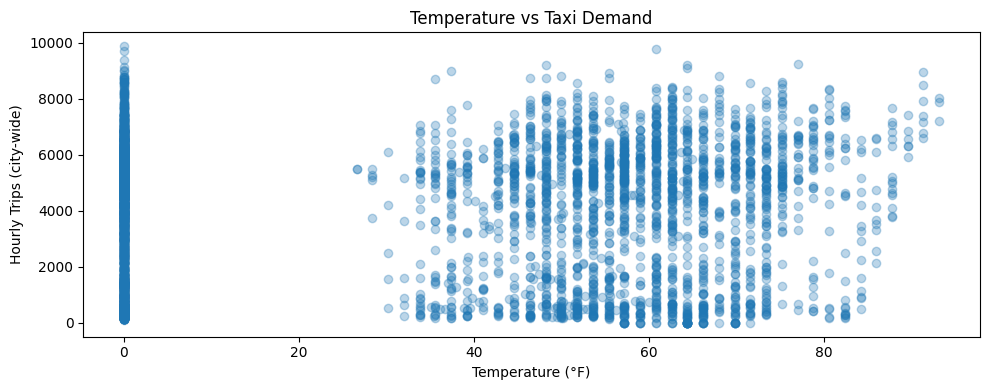

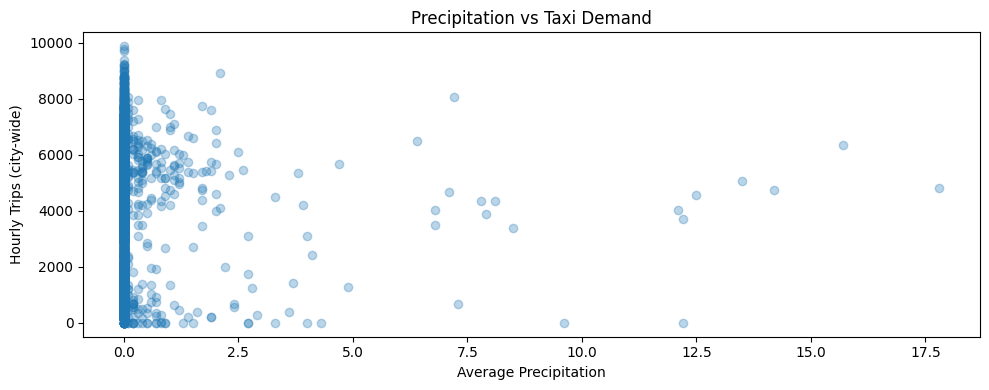

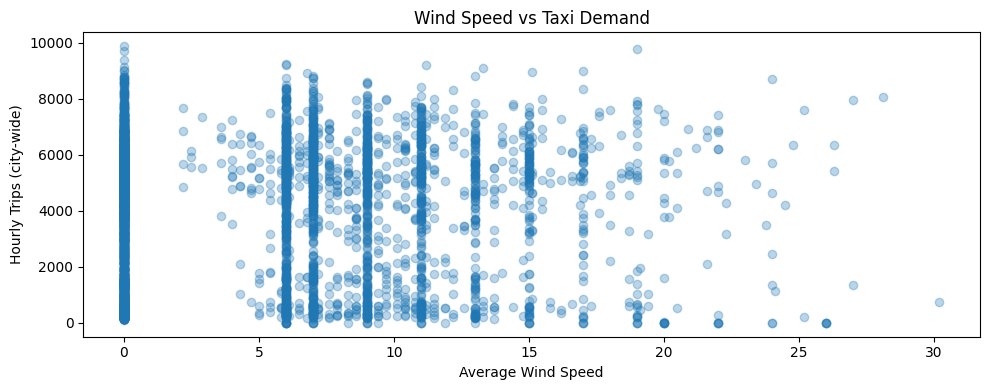

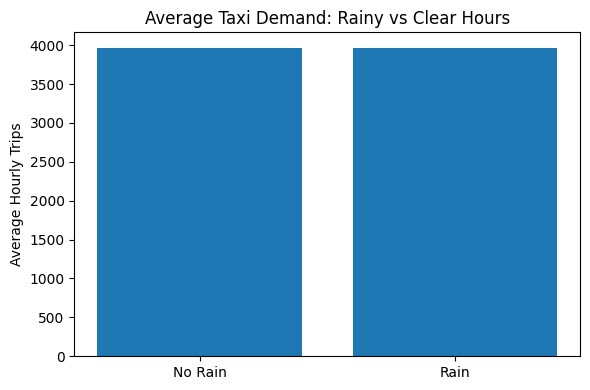

In [ ]:
# WEATHER IMPACT ANALYSIS – VISUALIZATIONS

# Convert to Pandas for plotting
weather_pd = weather_summary.toPandas()

# 1. Temperature vs demand
plt.figure(figsize=(10, 4))
plt.scatter(weather_pd["avg_temp_f"], weather_pd["total_trips"], alpha=0.3)
plt.xlabel("Temperature (°F)")
plt.ylabel("Hourly Trips (city-wide)")
plt.title("Temperature vs Taxi Demand")
plt.tight_layout()
plt.savefig("temp_vs_demand.png", dpi=150, bbox_inches="tight")
plt.show()

# 2. Precipitation vs demand
plt.figure(figsize=(10, 4))
plt.scatter(weather_pd["avg_prcp"], weather_pd["total_trips"], alpha=0.3)
plt.xlabel("Average Precipitation")
plt.ylabel("Hourly Trips (city-wide)")
plt.title("Precipitation vs Taxi Demand")
plt.tight_layout()
plt.savefig("prcp_vs_demand.png", dpi=150, bbox_inches="tight")
plt.show()

# 3. Wind speed vs demand
plt.figure(figsize=(10, 4))
plt.scatter(weather_pd["avg_wind_speed"], weather_pd["total_trips"], alpha=0.3)
plt.xlabel("Average Wind Speed")
plt.ylabel("Hourly Trips (city-wide)")
plt.title("Wind Speed vs Taxi Demand")
plt.tight_layout()
plt.savefig("wind_vs_demand.png", dpi=150, bbox_inches="tight")
plt.show()

# 4. Simple rainy vs clear bar chart
rain_stats_pd = rain_stats.toPandas()
rain_stats_pd["label"] = rain_stats_pd["is_rainy_hour"].map({0: "No Rain", 1: "Rain"})

plt.figure(figsize=(6, 4))
plt.bar(rain_stats_pd["label"], rain_stats_pd["avg_trips"])
plt.ylabel("Average Hourly Trips")
plt.title("Average Taxi Demand: Rainy vs Clear Hours")
plt.tight_layout()
plt.savefig("weather_rain_vs_clear.png", dpi=150, bbox_inches="tight")
plt.show()


### Holiday demand analysis

Compare daily taxi demand on major holidays (Labor Day, Columbus Day, Halloween, Veterans Day, Thanksgiving) to typical days in the same month, and visualize where holidays sit on the overall daily demand time series.


HOLIDAY DEMAND ANALYSIS

Sample daily demand:
+-----------+-----------+
|pickup_date|total_trips|
+-----------+-----------+
| 2023-09-01|      78986|
| 2023-09-02|      75125|
| 2023-09-03|      71219|
| 2023-09-04|      65327|
| 2023-09-05|      94056|
| 2023-09-06|     108094|
| 2023-09-07|     118388|
| 2023-09-08|     112297|
| 2023-09-09|     105600|
| 2023-09-10|      92674|
+-----------+-----------+
only showing top 10 rows


Holiday demand records:
+-----------+-----------+--------------------+----------+
|pickup_date|total_trips|        holiday_name|is_holiday|
+-----------+-----------+--------------------+----------+
| 2023-09-04|      65327|           Labor Day|         1|
| 2023-10-09|      77422|        Columbus Day|         1|
| 2023-10-31|      93470|           Halloween|         1|
| 2023-11-11|     112310|        Veterans Day|         1|
| 2023-11-23|      56484|        Thanksgiving|         1|
| 2023-12-25|      39843|       Christmas Day|         1|
| 2024-01-01|    

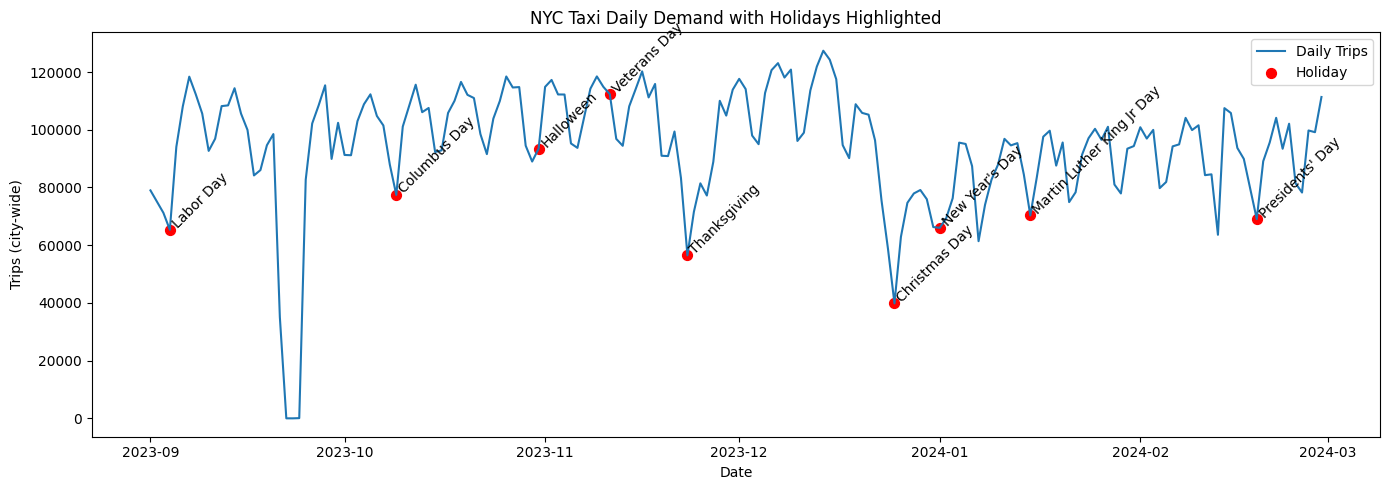

In [ ]:
# HOLIDAY DEMAND ANALYSIS
print("="*70)
print("HOLIDAY DEMAND ANALYSIS")
print("="*70)

from datetime import date

# Build daily demand table
# Add date column
daily_df = zone_hour_weather.withColumn(
    "pickup_date", F.to_date("pickup_hour_ts")
)

# Aggregate to daily demand (total trips city-wide)
daily_demand = daily_df.groupBy("pickup_date").agg(
    F.sum("trip_count").alias("total_trips")
).orderBy("pickup_date")

print("\nSample daily demand:")
daily_demand.show(10)

# Define holidays inside September 2023–February 2024
holiday_list = [
    ("Labor Day",         date(2023, 9, 4)),
    ("Columbus Day",      date(2023, 10, 9)),
    ("Halloween",         date(2023, 10, 31)),
    ("Veterans Day",      date(2023, 11, 11)),
    ("Thanksgiving",      date(2023, 11, 23)),
    ("Christmas Day",     date(2023, 12, 25)),
    ("New Year's Day",    date(2024, 1, 1)),
    ("Martin Luther King Jr Day", date(2024, 1, 15)),
    ("Presidents' Day",   date(2024, 2, 19)),
]

holiday_df = spark.createDataFrame(holiday_list, ["holiday_name", "holiday_date"])

# Join daily demand with holiday mapping
daily_with_holidays = daily_demand.join(
    holiday_df,
    daily_demand["pickup_date"] == holiday_df["holiday_date"],
    "left"
).drop("holiday_date")

# Create holiday indicator
daily_with_holidays = daily_with_holidays.withColumn(
    "is_holiday", F.when(F.col("holiday_name").isNotNull(), 1).otherwise(0)
)

print("\nHoliday demand records:")
daily_with_holidays.filter("is_holiday = 1").show()

# Holiday vs Non-Holiday comparison
print("\nAverage daily demand: holiday vs regular days")

holiday_stats = daily_with_holidays.groupBy("is_holiday").agg(
    F.avg("total_trips").alias("avg_daily_trips"),
    F.stddev("total_trips").alias("std_daily_trips"),
    F.count("*").alias("num_days")
).orderBy("is_holiday")

holiday_stats.show()

# Per-Holiday Detailed Comparison
print("\nDemand on each holiday vs monthly average:")

# Compute month-level average demand
monthly_avg = daily_with_holidays.withColumn(
    "month", F.month("pickup_date")
).groupBy("month").agg(
    F.avg("total_trips").alias("monthly_avg_trips")
)

# Join holiday table onto monthly averages
holiday_detail = daily_with_holidays.filter("is_holiday = 1") \
    .withColumn("month", F.month("pickup_date")) \
    .join(monthly_avg, on="month", how="left") \
    .select(
        "pickup_date",
        "holiday_name",
        "total_trips",
        "monthly_avg_trips",
        (F.col("total_trips") - F.col("monthly_avg_trips")).alias("diff_from_month_avg")
    )

holiday_detail.show()

# Visualization: daily time series with holidays marked
daily_sorted = daily_with_holidays.orderBy("pickup_date")

daily_pd = daily_sorted.toPandas()
daily_pd["pickup_date"] = pd.to_datetime(daily_pd["pickup_date"])

plt.figure(figsize=(14, 5))
plt.plot(daily_pd["pickup_date"], daily_pd["total_trips"], label="Daily Trips")

# Highlight holidays
holiday_pd = daily_pd[daily_pd["is_holiday"] == 1]
plt.scatter(holiday_pd["pickup_date"], holiday_pd["total_trips"], color="red", s=50, label="Holiday")

for _, row in holiday_pd.iterrows():
    plt.text(row["pickup_date"], row["total_trips"] + 500, row["holiday_name"], rotation=45)

plt.xlabel("Date")
plt.ylabel("Trips (city-wide)")
plt.title("NYC Taxi Daily Demand with Holidays Highlighted")
plt.legend()
plt.tight_layout()
plt.savefig("holiday_demand_timeseries.png", dpi=150)
plt.show()

### Daily demand heatmap

Reshape daily demand into a month–day grid and plot a heatmap to get a calendar-style view of which days are relatively busy or quiet.


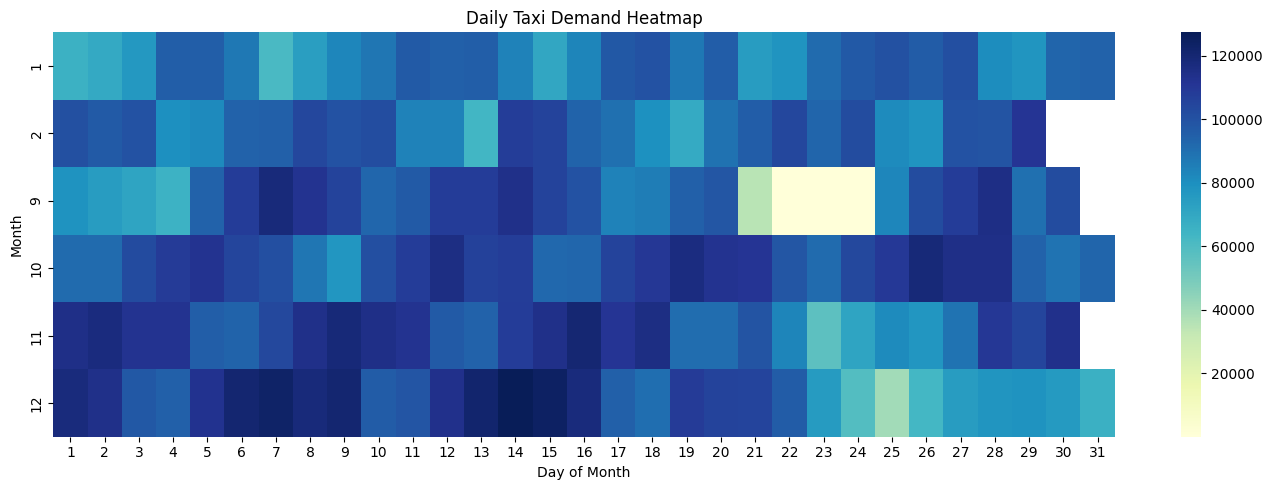

In [ ]:
# Extract calendar day and month for heatmap layout
daily_pd["day"] = daily_pd["pickup_date"].dt.day
daily_pd["month"] = daily_pd["pickup_date"].dt.month

# Pivot to month (rows) × day (columns) matrix of total trips
pivot = daily_pd.pivot_table(
    index="month", columns="day", values="total_trips"
)

plt.figure(figsize=(14, 5))
sns.heatmap(pivot, cmap="YlGnBu", cbar=True)
plt.title("Daily Taxi Demand Heatmap")
plt.xlabel("Day of Month")
plt.ylabel("Month")
plt.tight_layout()
plt.show()


In [ ]:
daily_pd = daily_with_holidays.toPandas()

# Ensure pickup_date is a datetime column
daily_pd["pickup_date"] = pd.to_datetime(daily_pd["pickup_date"])


### Weekly demand with holiday markers

Aggregate demand at the weekly level and highlight weeks that contain holidays to see whether holiday weeks stand out compared to surrounding weeks.


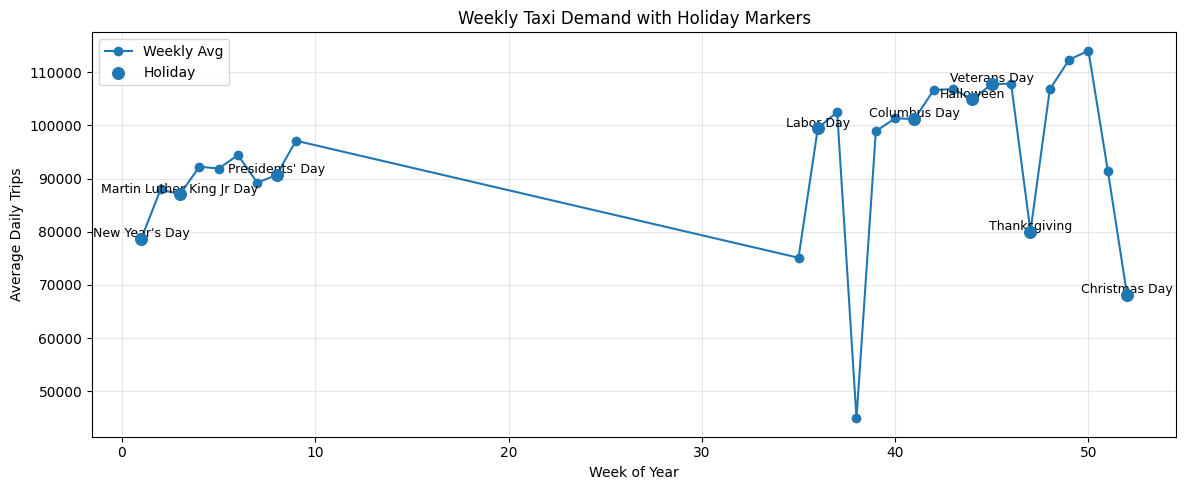

In [ ]:
daily_with_week = daily_with_holidays.withColumn(
    "week", F.weekofyear("pickup_date")
)

# Weekly average demand (average daily trips per week), sorted by week
weekly_df = daily_with_week.groupBy("week").agg(
    F.avg("total_trips").alias("avg_trips")
).orderBy("week")

weekly_pd = weekly_df.toPandas()

# Get one row per holiday week, then attach the weekly average
holiday_weeks_df = daily_with_week.filter("is_holiday = 1") \
    .select("week", "holiday_name") \
    .distinct()

holiday_weeks_pd = holiday_weeks_df.toPandas().merge(
    weekly_pd, on="week", how="left"
)

# ---- Plot ----
plt.figure(figsize=(12, 5))

# Weekly average line
plt.plot(weekly_pd["week"], weekly_pd["avg_trips"],
         marker="o", label="Weekly Avg")

# Holiday markers at the weekly average level
plt.scatter(holiday_weeks_pd["week"], holiday_weeks_pd["avg_trips"],
            s=70, label="Holiday", zorder=5)

for _, row in holiday_weeks_pd.iterrows():
    plt.text(row["week"], row["avg_trips"] + 300,
             row["holiday_name"], ha="center", fontsize=9)

plt.xlabel("Week of Year")
plt.ylabel("Average Daily Trips")
plt.title("Weekly Taxi Demand with Holiday Markers")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
holiday_detail.show()

+-----------+--------------------+-----------+------------------+-------------------+
|pickup_date|        holiday_name|total_trips| monthly_avg_trips|diff_from_month_avg|
+-----------+--------------------+-----------+------------------+-------------------+
| 2023-11-11|        Veterans Day|     112310|          101299.5|            11010.5|
| 2023-10-09|        Columbus Day|      77422|102773.32258064517|-25351.322580645166|
| 2023-10-31|           Halloween|      93470|102773.32258064517| -9303.322580645166|
| 2023-09-04|           Labor Day|      65327| 85157.26666666666|-19830.266666666663|
| 2023-11-23|        Thanksgiving|      56484|          101299.5|           -44815.5|
| 2023-12-25|       Christmas Day|      39843| 97800.12903225806| -57957.12903225806|
| 2024-02-19|     Presidents' Day|      69041|  92626.6551724138|-23585.655172413797|
| 2024-01-01|      New Year's Day|      66011| 86688.29032258065| -20677.29032258065|
| 2024-01-15|Martin Luther Kin...|      70312| 86688.2

---
## 7. Feature Engineering <a name="7-feature-engineering"></a>

Build a modeling-ready feature set by enriching the zone–hour demand data with temporal features (hour of day, day of week, month, weekend and rush-hour flags), weather indicators, and history-based demand features (lags and rolling averages like demand 1 hour ago, 24 hours ago, or over the last few hours). This transforms the raw time series into a rich input matrix for machine learning.


In [ ]:
print("=" * 70)
print("FEATURE ENGINEERING")
print("=" * 70)

# Extract temporal features
df_features = zone_hour_weather.withColumn("hour", F.hour("pickup_hour_ts")) \
    .withColumn("day_of_week", F.dayofweek("pickup_hour_ts")) \
    .withColumn("day_of_month", F.dayofmonth("pickup_hour_ts")) \
    .withColumn("month", F.month("pickup_hour_ts")) \
    .withColumn("week_of_year", F.weekofyear("pickup_hour_ts"))

# Create derived temporal features
df_features = df_features.withColumn(
    "is_weekend",
    F.when(F.col("day_of_week").isin([1, 7]), 1).otherwise(0)
)

df_features = df_features.withColumn(
    "is_rush_hour",
    F.when(
        ((F.col("hour") >= 7) & (F.col("hour") <= 9)) |
        ((F.col("hour") >= 17) & (F.col("hour") <= 19)),
        1
    ).otherwise(0)
)

df_features = df_features.withColumn(
    "is_night",
    F.when((F.col("hour") >= 22) | (F.col("hour") <= 5), 1).otherwise(0)
)

# Time period categories
df_features = df_features.withColumn(
    "time_period",
    F.when((F.col("hour") >= 6) & (F.col("hour") < 12), "morning")
    .when((F.col("hour") >= 12) & (F.col("hour") < 17), "afternoon")
    .when((F.col("hour") >= 17) & (F.col("hour") < 21), "evening")
    .otherwise("night")
)

print(" Temporal features created")

FEATURE ENGINEERING
 Temporal features created


In [ ]:
# Create lag features (previous hour/day demand)
window_zone = Window.partitionBy("LocationID").orderBy("pickup_hour_ts")

# Lag features
df_features = df_features.withColumn("demand_lag_1h", F.lag("trip_count", 1).over(window_zone))
df_features = df_features.withColumn("demand_lag_2h", F.lag("trip_count", 2).over(window_zone))
df_features = df_features.withColumn("demand_lag_3h", F.lag("trip_count", 3).over(window_zone))
df_features = df_features.withColumn("demand_lag_24h", F.lag("trip_count", 24).over(window_zone))
df_features = df_features.withColumn("demand_lag_168h", F.lag("trip_count", 168).over(window_zone))  # 1 week ago

# Rolling average features
window_3h = Window.partitionBy("LocationID").orderBy("pickup_hour_ts").rowsBetween(-3, -1)
window_6h = Window.partitionBy("LocationID").orderBy("pickup_hour_ts").rowsBetween(-6, -1)
window_24h = Window.partitionBy("LocationID").orderBy("pickup_hour_ts").rowsBetween(-24, -1)

df_features = df_features.withColumn("demand_avg_3h", F.avg("trip_count").over(window_3h))
df_features = df_features.withColumn("demand_avg_6h", F.avg("trip_count").over(window_6h))
df_features = df_features.withColumn("demand_avg_24h", F.avg("trip_count").over(window_24h))

# Fill null lag values with 0
lag_cols = ['demand_lag_1h', 'demand_lag_2h', 'demand_lag_3h', 'demand_lag_24h', 'demand_lag_168h',
            'demand_avg_3h', 'demand_avg_6h', 'demand_avg_24h']
for col in lag_cols:
    df_features = df_features.fillna({col: 0})

print(" Lag and rolling features created")

 Lag and rolling features created


In [ ]:
# Join with zone information for borough features
df_features = df_features.join(
    zones_df.select("LocationID", "Zone", "Borough"),
    "LocationID",
    "left"
)

# Create borough one-hot encoding (using StringIndexer for ML)
borough_indexer = StringIndexer(inputCol="Borough", outputCol="borough_index", handleInvalid="keep")
df_features = borough_indexer.fit(df_features).transform(df_features)

print(" Zone and borough features added")

 Zone and borough features added


In [ ]:
# Cyclical encoding for hour and day
df_features = df_features.withColumn("hour_sin", F.sin(2 * np.pi * F.col("hour") / 24))
df_features = df_features.withColumn("hour_cos", F.cos(2 * np.pi * F.col("hour") / 24))
df_features = df_features.withColumn("dow_sin", F.sin(2 * np.pi * F.col("day_of_week") / 7))
df_features = df_features.withColumn("dow_cos", F.cos(2 * np.pi * F.col("day_of_week") / 7))
df_features = df_features.withColumn("month_sin", F.sin(2 * np.pi * F.col("month") / 12))
df_features = df_features.withColumn("month_cos", F.cos(2 * np.pi * F.col("month") / 12))

print(" Cyclical encoding complete")

 Cyclical encoding complete


In [ ]:
# Cache final feature DataFrame
df_features = df_features.cache()

print(f"\n Feature Engineering Complete!")
print(f" Total Features: {len(df_features.columns)}")
print(f" Total Records: {df_features.count():,}")

print("\n Final Feature List:")
for i, col in enumerate(df_features.columns, 1):
    print(f"   {i:2d}. {col}")


 Feature Engineering Complete!
 Total Features: 49
 Total Records: 389,600

 Final Feature List:
    1. LocationID
    2. pickup_hour_ts
    3. trip_count
    4. total_passengers
    5. total_fare
    6. avg_fare
    7. total_tips
    8. avg_tip
    9. total_revenue
   10. avg_distance
   11. avg_duration
   12. avg_speed
   13. fare_stddev
   14. min_fare
   15. max_fare
   16. temp_f
   17. rhum
   18. prcp
   19. snow
   20. wspd
   21. is_rainy
   22. is_snowy
   23. is_windy
   24. hour
   25. day_of_week
   26. day_of_month
   27. month
   28. week_of_year
   29. is_weekend
   30. is_rush_hour
   31. is_night
   32. time_period
   33. demand_lag_1h
   34. demand_lag_2h
   35. demand_lag_3h
   36. demand_lag_24h
   37. demand_lag_168h
   38. demand_avg_3h
   39. demand_avg_6h
   40. demand_avg_24h
   41. Zone
   42. Borough
   43. borough_index
   44. hour_sin
   45. hour_cos
   46. dow_sin
   47. dow_cos
   48. month_sin
   49. month_cos


In [ ]:
# Show sample of feature DataFrame
print("\n Sample Feature Data:")
df_features.select(
    "LocationID", "Zone", "pickup_hour_ts", "trip_count",
    "hour", "day_of_week", "is_weekend", "is_rush_hour",
    "temp_f", "is_rainy", "demand_lag_1h", "demand_avg_24h"
).show(10, truncate=False)


 Sample Feature Data:
+----------+-----------------------+-------------------+----------+----+-----------+----------+------------+------+--------+-------------+--------------+
|LocationID|Zone                   |pickup_hour_ts     |trip_count|hour|day_of_week|is_weekend|is_rush_hour|temp_f|is_rainy|demand_lag_1h|demand_avg_24h|
+----------+-----------------------+-------------------+----------+----+-----------+----------+------------+------+--------+-------------+--------------+
|3         |Allerton/Pelham Gardens|2023-09-01 05:00:00|1         |5   |6          |0         |0           |66.2  |0       |0            |0.0           |
|3         |Allerton/Pelham Gardens|2023-09-01 08:00:00|1         |8   |6          |0         |1           |62.6  |0       |1            |1.0           |
|3         |Allerton/Pelham Gardens|2023-09-01 09:00:00|1         |9   |6          |0         |1           |62.6  |0       |1            |1.0           |
|3         |Allerton/Pelham Gardens|2023-09-01 13:00:

---
## 8. Machine Learning with Spark MLlib <a name="8-machine-learning"></a>

Train and compare multiple regression models (such as Linear Regression, Random Forest, and Gradient-Boosted Trees) using Spark ML pipelines. We assemble the engineered features into a vector, perform a time-aware train/test split, tune model hyperparameters, and compute core metrics (RMSE, MAE, R²) to identify the best-performing model for hourly demand prediction.


In [ ]:
print("=" * 70)
print("MACHINE LEARNING WITH SPARK MLLIB")
print("=" * 70)

# Select features for model
feature_columns = [
    # Temporal features
    'hour', 'day_of_week', 'day_of_month', 'month',
    'is_weekend', 'is_rush_hour', 'is_night',
    'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos',

    # Location features
    'LocationID', 'borough_index',

    # Weather features
    'temp_f', 'rhum', 'prcp', 'wspd',
    'is_rainy', 'is_snowy', 'is_windy',

    # Lag features
    'demand_lag_3h',
    'demand_lag_24h', 'demand_lag_168h',
    'demand_avg_3h', 'demand_avg_6h', 'demand_avg_24h',

    # Trip characteristics from aggregation
    'avg_fare', 'avg_distance', 'avg_duration'
]

# Target variable
target = 'trip_count'

print(f"\n Number of Features: {len(feature_columns)}")
print(f" Target Variable: {target}")

MACHINE LEARNING WITH SPARK MLLIB

 Number of Features: 29
 Target Variable: trip_count


In [ ]:
# Prepare ML DataFrame - remove rows with null in features
df_ml = df_features.select(feature_columns + [target, 'pickup_hour_ts'])
df_ml = df_ml.dropna()

print(f"\n ML Dataset Size: {df_ml.count():,} records")


 ML Dataset Size: 389,600 records


In [ ]:
# Time-based train/test split (use last week as test)
split_date = "2024-02-23"  # Last week of February 2024 for testing

train_df = df_ml.filter(F.col("pickup_hour_ts") < split_date)
test_df = df_ml.filter(F.col("pickup_hour_ts") >= split_date)

train_count = train_df.count()
test_count = test_df.count()

print(f"\n Training Set: {train_count:,} records ({train_count/(train_count+test_count)*100:.1f}%)")
print(f" Test Set: {test_count:,} records ({test_count/(train_count+test_count)*100:.1f}%)")


 Training Set: 373,345 records (95.8%)
 Test Set: 16,255 records (4.2%)


In [ ]:
# Create feature vector
assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol="features_raw",
    handleInvalid="skip"
)

# Scale features
scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withStd=True,
    withMean=True
)

print(" Feature assembler and scaler configured")

 Feature assembler and scaler configured


In [ ]:
# Define models
models = {
    "Linear Regression": LinearRegression(
        featuresCol="features",
        labelCol=target,
        maxIter=100,
        regParam=0.1,
        elasticNetParam=0.5
    ),
    "Random Forest": RandomForestRegressor(
        featuresCol="features",
        labelCol=target,
        numTrees=50,
        maxDepth=10,
        seed=42
    ),
    "Gradient Boosted Trees": GBTRegressor(
        featuresCol="features",
        labelCol=target,
        maxIter=10,
        maxDepth=4,
        maxBins=32,
        subsamplingRate=0.7,
        stepSize=0.1
    )
}

print(f"\n Models to train: {list(models.keys())}")


 Models to train: ['Linear Regression', 'Random Forest', 'Gradient Boosted Trees']


In [ ]:
# Train and evaluate models
evaluator_rmse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2")

results = {}
trained_models = {}

print("\n" + "=" * 70)
print("TRAINING MODELS")
print("=" * 70)

for model_name, model in models.items():
    print(f"\n Training {model_name}...")

    # Build pipeline
    pipeline = Pipeline(stages=[assembler, scaler, model])

    # Train model
    import time
    start_time = time.time()
    pipeline_model = pipeline.fit(train_df)
    train_time = time.time() - start_time

    # Predictions
    predictions = pipeline_model.transform(test_df)

    # Evaluate
    rmse = evaluator_rmse.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)

    results[model_name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Train Time (s)': train_time
    }

    trained_models[model_name] = pipeline_model

    print(f"   {model_name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}, Time: {train_time:.1f}s")


TRAINING MODELS

 Training Linear Regression...
   Linear Regression - RMSE: 20.53, MAE: 10.17, R²: 0.9195, Time: 15.1s

 Training Random Forest...
   Random Forest - RMSE: 17.55, MAE: 7.87, R²: 0.9412, Time: 137.8s

 Training Gradient Boosted Trees...
   Gradient Boosted Trees - RMSE: 23.65, MAE: 11.08, R²: 0.8932, Time: 23.9s


In [ ]:
# Display results comparison
print("\n" + "=" * 70)
print("MODEL COMPARISON RESULTS")
print("=" * 70)

results_df = pd.DataFrame(results).T
results_df = results_df.round(4)
print(results_df.to_string())

# Identify best model
best_model_name = results_df['R2'].idxmax()
print(f"\n Best Model: {best_model_name} (R² = {results_df.loc[best_model_name, 'R2']:.4f})")


MODEL COMPARISON RESULTS
                           RMSE      MAE      R2  Train Time (s)
Linear Regression       20.5318  10.1749  0.9195         15.1016
Random Forest           17.5473   7.8675  0.9412        137.8487
Gradient Boosted Trees  23.6524  11.0798  0.8932         23.9018

 Best Model: Random Forest (R² = 0.9412)


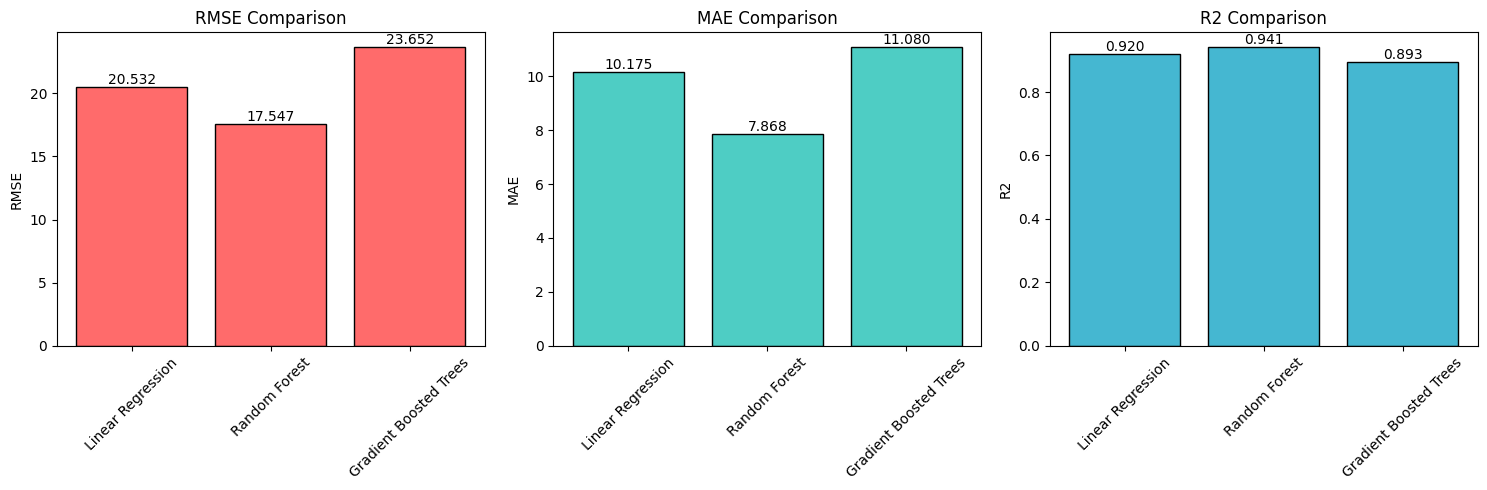

In [ ]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['RMSE', 'MAE', 'R2']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for ax, metric, color in zip(axes, metrics, colors):
    values = [results[m][metric] for m in results.keys()]
    bars = ax.bar(results.keys(), values, color=color, edgecolor='black')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison')
    ax.tick_params(axis='x', rotation=45)

    # Add value labels
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{val:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 9. Model Evaluation & Results <a name="9-model-evaluation"></a>

Evaluate the selected best model in detail on the hold-out test period. We inspect prediction quality via scatter plots and time-series comparisons of actual vs. predicted demand, analyze errors by hour of day, and, for tree-based models, examine feature importance to understand which variables most strongly drive taxi demand forecasts.


In [ ]:
print("=" * 70)
print("DETAILED MODEL EVALUATION")
print("=" * 70)

# Use best model for detailed evaluation
best_model = trained_models[best_model_name]
predictions = best_model.transform(test_df)

# Get predictions as Pandas for visualization
pred_pd = predictions.select(
    'LocationID', 'pickup_hour_ts', 'trip_count', 'prediction',
    'hour', 'day_of_week', 'is_weekend'
).toPandas()

pred_pd['error'] = pred_pd['trip_count'] - pred_pd['prediction']
pred_pd['abs_error'] = abs(pred_pd['error'])
pred_pd['pct_error'] = (pred_pd['abs_error'] / (pred_pd['trip_count'] + 1)) * 100

print(f"\n Prediction Statistics:")
print(f"   Mean Absolute Error: {pred_pd['abs_error'].mean():.2f} trips")
print(f"   Median Absolute Error: {pred_pd['abs_error'].median():.2f} trips")
print(f"   Mean Percentage Error: {pred_pd['pct_error'].mean():.2f}%")

DETAILED MODEL EVALUATION

 Prediction Statistics:
   Mean Absolute Error: 7.87 trips
   Median Absolute Error: 1.74 trips
   Mean Percentage Error: 34.75%


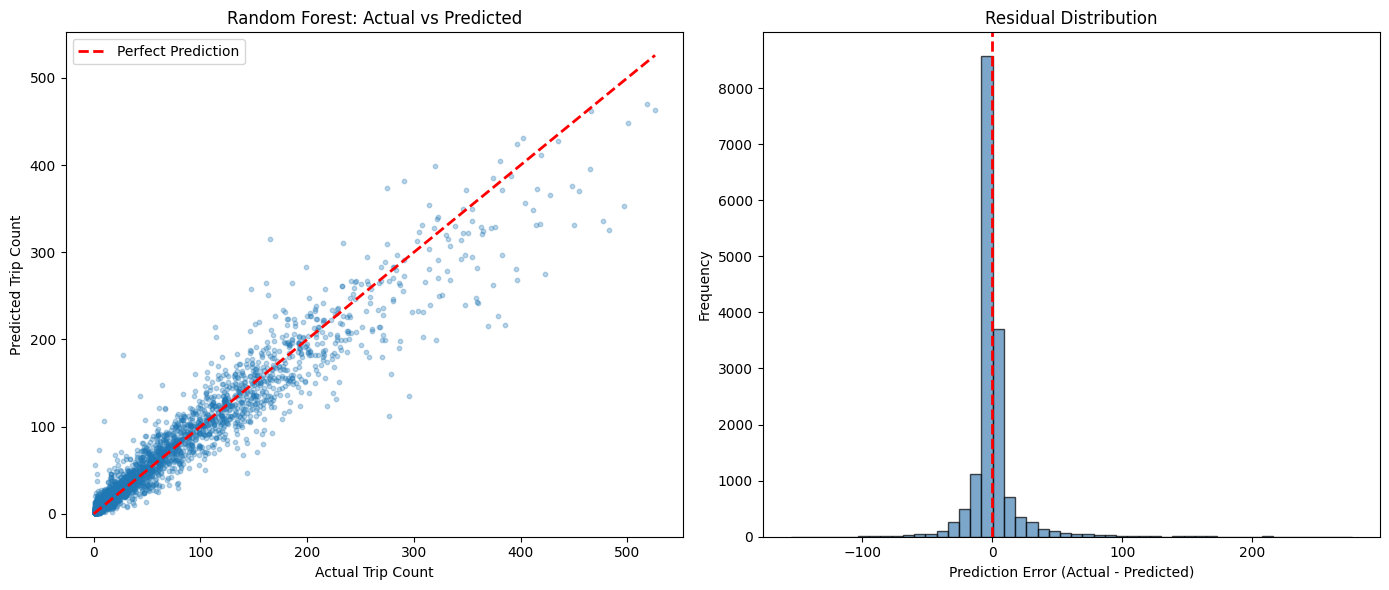

In [ ]:
# Actual vs Predicted scatter plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot
sample = pred_pd.sample(min(5000, len(pred_pd)))
axes[0].scatter(sample['trip_count'], sample['prediction'], alpha=0.3, s=10)
max_val = max(sample['trip_count'].max(), sample['prediction'].max())
axes[0].plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Trip Count')
axes[0].set_ylabel('Predicted Trip Count')
axes[0].set_title(f'{best_model_name}: Actual vs Predicted')
axes[0].legend()

# Residual distribution
axes[1].hist(pred_pd['error'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', lw=2)
axes[1].set_xlabel('Prediction Error (Actual - Predicted)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')

plt.tight_layout()
plt.savefig('prediction_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

#### Performance by time period

Recompute model metrics over different calendar windows (for example, individual months) to see how prediction accuracy changes over time and to check whether certain periods, such as holiday-heavy months, are harder to forecast than others.


In [ ]:
# PERFORMANCE BY TIME PERIOD
print("=" * 70)
print("PERFORMANCE BY TIME PERIOD")
print("=" * 70)

# Define the periods to evaluate
evaluation_periods = [
    ("2023-09-01", "2023-10-01", "Sep 2023"),
    ("2023-10-01", "2023-11-01", "Oct 2023"),
    ("2023-11-01", "2023-12-01", "Nov 2023"),
    ("2023-12-01", "2024-01-01", "Dec 2023"),
    ("2024-01-01", "2024-02-01", "Jan 2024"),
    ("2024-02-01", "2024-03-01", "Feb 2024"),
]

period_metrics = []

for start, end, label in evaluation_periods:
    print(f"\nEvaluating period: {label} ({start} to {end})")

    # Filter the ML dataset to this time window
    period_df = df_ml.filter(
        (F.col("pickup_hour_ts") >= start) &
        (F.col("pickup_hour_ts") <  end)
    )

    row_count = period_df.count()
    print(f"  Rows in period: {row_count:,}")

    if row_count == 0:
        print("  (Skipping – no data in this range)")
        continue

    # Use the already-trained best_model to get predictions
    period_preds = best_model.transform(period_df)

    # Reuse the evaluators already defined earlier
    rmse = evaluator_rmse.evaluate(period_preds)
    mae  = evaluator_mae.evaluate(period_preds)
    r2   = evaluator_r2.evaluate(period_preds)

    period_metrics.append({
        "Period": label,
        "Start": start,
        "End": end,
        "Rows": row_count,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
    })

if period_metrics:
    period_results_df = pd.DataFrame(period_metrics)
    print("\nPerformance of best model by time period:")
    print(period_results_df.to_string(index=False))
else:
    print("\nNo non-empty periods to report.")


PERFORMANCE BY TIME PERIOD

Evaluating period: Sep 2023 (2023-09-01 to 2023-10-01)
  Rows in period: 57,850

Evaluating period: Oct 2023 (2023-10-01 to 2023-11-01)
  Rows in period: 67,766

Evaluating period: Nov 2023 (2023-11-01 to 2023-12-01)
  Rows in period: 64,913

Evaluating period: Dec 2023 (2023-12-01 to 2024-01-01)
  Rows in period: 67,290

Evaluating period: Jan 2024 (2024-01-01 to 2024-02-01)
  Rows in period: 67,084

Evaluating period: Feb 2024 (2024-02-01 to 2024-03-01)
  Rows in period: 64,697

Performance of best model by time period:
  Period      Start        End  Rows      RMSE      MAE       R2
Sep 2023 2023-09-01 2023-10-01 57850 17.609143 8.494769 0.941462
Oct 2023 2023-10-01 2023-11-01 67766 15.771210 7.784586 0.958906
Nov 2023 2023-11-01 2023-12-01 64913 17.260517 8.286561 0.952225
Dec 2023 2023-12-01 2024-01-01 67290 16.695941 8.112696 0.950816
Jan 2024 2024-01-01 2024-02-01 67084 16.537407 7.763217 0.941963
Feb 2024 2024-02-01 2024-03-01 64697 16.469412 7.74531

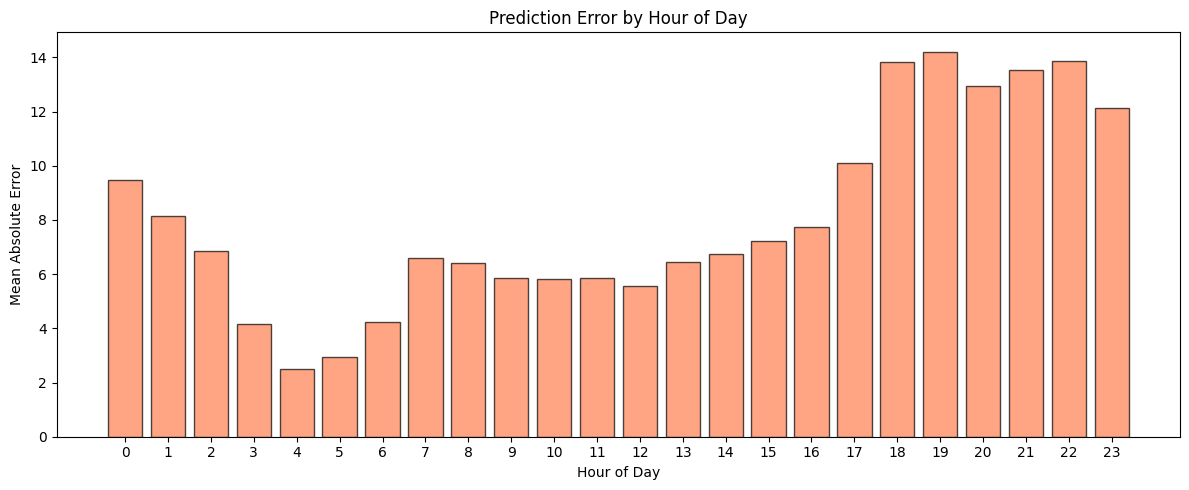

In [ ]:
# Error by hour of day
error_by_hour = pred_pd.groupby('hour').agg({
    'abs_error': 'mean',
    'trip_count': 'mean'
}).reset_index()

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(error_by_hour['hour'], error_by_hour['abs_error'], color='coral', edgecolor='black', alpha=0.7)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('Prediction Error by Hour of Day')
ax.set_xticks(range(24))
plt.tight_layout()
plt.savefig('error_by_hour.png', dpi=150, bbox_inches='tight')
plt.show()

### Feature importance

Extract and visualize feature importances from the tree-based model to understand which variables (lags, rolling averages, time features, etc.) have the largest impact on predicted taxi demand.



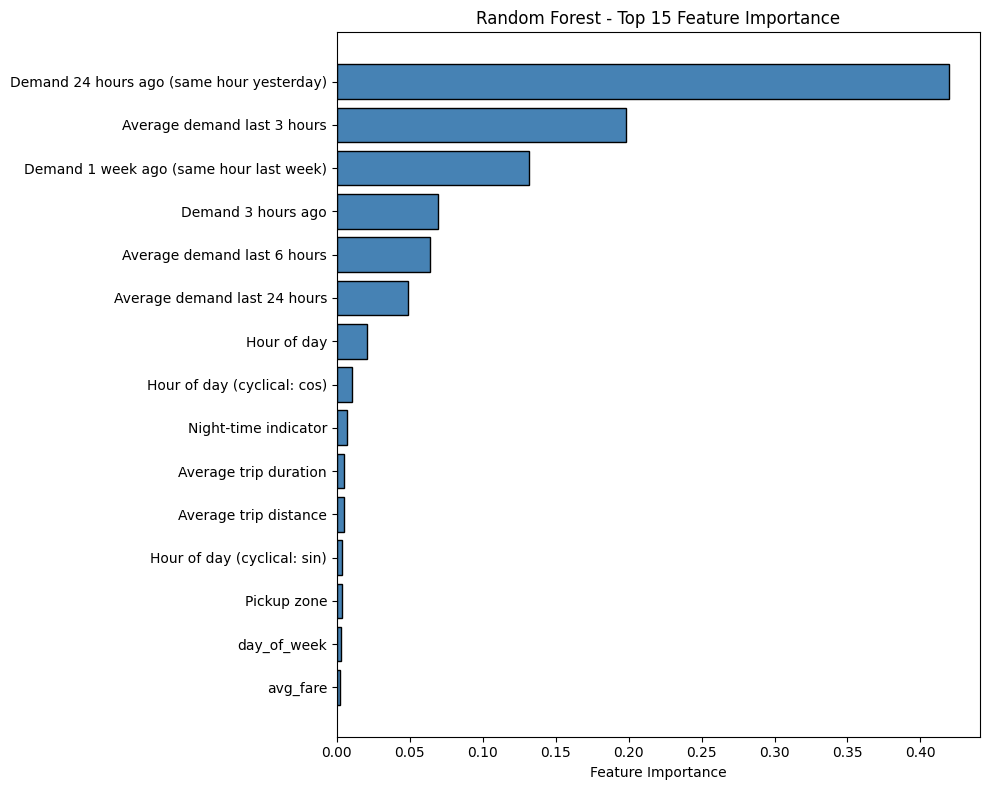


Top 15 Most Important Features (user-friendly names):
                                  feature  importance
Demand 24 hours ago (same hour yesterday)    0.419870
              Average demand last 3 hours    0.198496
  Demand 1 week ago (same hour last week)    0.131402
                       Demand 3 hours ago    0.069246
              Average demand last 6 hours    0.063556
             Average demand last 24 hours    0.048623
                              Hour of day    0.020394
              Hour of day (cyclical: cos)    0.010527
                     Night-time indicator    0.007004
                    Average trip duration    0.005106
                    Average trip distance    0.004572
              Hour of day (cyclical: sin)    0.003869
                              Pickup zone    0.003528
                              day_of_week    0.002565
                                 avg_fare    0.002464


In [ ]:
if best_model_name in ["Random Forest", "Gradient Boosted Trees"]:
    # Get the model from pipeline
    rf_model = best_model.stages[-1]

    # Raw importances
    importance = rf_model.featureImportances.toArray()

    importance_df = pd.DataFrame({
        "feature": feature_columns,
        "importance": importance
    }).sort_values("importance", ascending=False)

    feature_name_map = {
        "demand_lag_1h":   "Demand 1 hour ago",
        "demand_lag_2h":   "Demand 2 hours ago",
        "demand_lag_3h":   "Demand 3 hours ago",
        "demand_lag_24h":  "Demand 24 hours ago (same hour yesterday)",
        "demand_lag_168h": "Demand 1 week ago (same hour last week)",
        "demand_avg_3h":   "Average demand last 3 hours",
        "demand_avg_6h":   "Average demand last 6 hours",
        "demand_avg_24h":  "Average demand last 24 hours",
        "hour":            "Hour of day",
        "hour_sin":        "Hour of day (cyclical: sin)",
        "hour_cos":        "Hour of day (cyclical: cos)",
        "is_night":        "Night-time indicator",
        "avg_duration":    "Average trip duration",
        "avg_distance":    "Average trip distance",
        "LocationID":      "Pickup zone",
    }

    importance_df["feature"] = importance_df["feature"].map(
        lambda x: feature_name_map.get(x, x)
    )

    # -----------------------------
    # Plot top 15 features
    # -----------------------------
    top_features = importance_df.head(15)

    plt.figure(figsize=(10, 8))
    plt.barh(top_features["feature"], top_features["importance"],
             color="steelblue", edgecolor="black")
    plt.xlabel("Feature Importance")
    plt.title(f"{best_model_name} - Top 15 Feature Importance")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig("feature_importance.png", dpi=150, bbox_inches="tight")
    plt.show()

    print("\nTop 15 Most Important Features (user-friendly names):")
    print(top_features.to_string(index=False))

---
## 10. Export for Dashboard <a name="10-export-for-dashboard"></a>

Export curated, analysis-ready datasets to CSV. This includes zone–hour demand with weather, hourly and daily summaries, zone-level aggregates, model predictions, model comparison results, and feature importance, as well as a compressed archive for convenient download.


In [ ]:
print("=" * 70)
print("EXPORTING DATA FOR DASHBOARD")
print("=" * 70)

import os
os.makedirs("dashboard_data", exist_ok=True)

# -----------------------------
# Export 1: Zone-Hour Aggregated Data (for heatmaps)
# -----------------------------
(
    zone_hour_weather
        .select(
            "LocationID", "pickup_hour_ts", "trip_count",
            "total_fare", "avg_fare", "avg_distance", "avg_duration",
            "temp_f", "prcp", "is_rainy"
        )
        .coalesce(1)
        .write
        .mode("overwrite")
        .option("header", True)
        .csv("dashboard_data/zone_hour_data")
)

print(" Exported zone_hour_data as Spark CSV (dashboard_data/zone_hour_data/*)")

# -----------------------------
# Export 2: Hourly aggregation (for time series)
# -----------------------------
hourly_export = hourly_pd.copy()
hourly_export.to_csv("dashboard_data/hourly_summary.csv", index=False)
print(f" Exported hourly_summary.csv ({len(hourly_export):,} rows)")

# -----------------------------
# Export 3: Daily aggregation (for calendar view)
# -----------------------------
daily_summary = daily_pd.copy()   # or daily_with_holidays
daily_summary.to_csv("dashboard_data/daily_summary.csv", index=False)
print(f" Exported daily_summary.csv ({len(daily_summary):,} rows)")

# -----------------------------
# Export 4: Zone summary (for maps)
# -----------------------------
(
    df_features
        .groupBy("LocationID", "Zone", "Borough")
        .agg(
            F.sum("trip_count").alias("total_trips"),
            F.avg("trip_count").alias("avg_hourly_demand"),
            F.avg("avg_fare").alias("avg_fare"),
            F.sum("total_revenue").alias("total_revenue")
        )
        .coalesce(1)
        .write
        .mode("overwrite")
        .option("header", True)
        .csv("dashboard_data/zone_summary")
)

print(" Exported zone_summary as Spark CSV (dashboard_data/zone_summary/*)")

# -----------------------------
# Export 5: Predictions (for model analysis)
# -----------------------------
pred_pd.to_csv("dashboard_data/predictions.csv", index=False)
print(f" Exported predictions.csv ({len(pred_pd):,} rows)")

# -----------------------------
# Export 6: Model results
# -----------------------------
results_df.to_csv("dashboard_data/model_results.csv", index=False)
print(" Exported model_results.csv")

# -----------------------------
# Export 7: Feature importance
# -----------------------------
if "importance_df" in dir():
    importance_df.to_csv("dashboard_data/feature_importance.csv", index=False)
    print(" Exported feature_importance.csv")


EXPORTING DATA FOR DASHBOARD
 Exported zone_hour_data as Spark CSV (dashboard_data/zone_hour_data/*)
 Exported hourly_summary.csv (24 rows)
 Exported daily_summary.csv (182 rows)
 Exported zone_summary as Spark CSV (dashboard_data/zone_summary/*)
 Exported predictions.csv (16,255 rows)
 Exported model_results.csv
 Exported feature_importance.csv


In [ ]:
# Create a compressed archive for easy download
import shutil
shutil.make_archive('dashboard_data', 'zip', 'dashboard_data')
print(f"\n Created dashboard_data.zip for download")


 Created dashboard_data.zip for download


In [ ]:
# Zone-level summary (small aggregation -> safe to toPandas)
zone_summary = (
    df_features
    .groupBy("LocationID", "Zone", "Borough")
    .agg(
        F.sum("trip_count").alias("total_trips"),
        F.avg("trip_count").alias("avg_hourly_demand"),
        F.avg("avg_fare").alias("avg_fare"),
        F.sum("total_revenue").alias("total_revenue")
    )
    .toPandas()  # this is safe: only ~260 zones, not millions of rows
)

print("Zone summary shape:", zone_summary.shape)


Zone summary shape: (255, 7)


In [ ]:
# Summary statistics for report
print("\n" + "=" * 70)
print("PROJECT SUMMARY STATISTICS")
print("=" * 70)

print(f"\n DATA OVERVIEW")
print(f"   • Analysis Period: September 2023 - February 2024")
print(f"   • Total Raw Records: {original_count:,}")
print(f"   • Clean Records: {final_count:,}")
print(f"   • Data Retention Rate: {(final_count/original_count)*100:.1f}%")
print(f"   • Unique Taxi Zones: {zone_summary['LocationID'].nunique()}")

print(f"\n KEY METRICS")
print(f"   • Total Trips: {zone_summary['total_trips'].sum():,.0f}")
print(f"   • Total Revenue: ${zone_summary['total_revenue'].sum():,.2f}")
print(f"   • Average Fare: ${zone_summary['avg_fare'].mean():.2f}")

print(f"\n MODEL PERFORMANCE")
print(f"   • Best Model: {best_model_name}")
print(f"   • R² Score: {results[best_model_name]['R2']:.4f}")
print(f"   • RMSE: {results[best_model_name]['RMSE']:.2f} trips")
print(f"   • MAE: {results[best_model_name]['MAE']:.2f} trips")

print(f"\n EXPORTED FILES")
print(f"   • zone_hour_data.csv - Zone-level hourly aggregations")
print(f"   • hourly_summary.csv - Overall hourly patterns")
print(f"   • daily_summary.csv - Daily time series")
print(f"   • zone_summary.csv - Zone-level statistics")
print(f"   • predictions.csv - Model predictions")
print(f"   • model_results.csv - Model comparison")
print(f"   • feature_importance.csv - Feature rankings")



PROJECT SUMMARY STATISTICS

 DATA OVERVIEW
   • Analysis Period: September 2023 - February 2024
   • Total Raw Records: 19,057,439
   • Clean Records: 17,184,990
   • Data Retention Rate: 90.2%
   • Unique Taxi Zones: 255

 KEY METRICS
   • Total Trips: 17,184,990
   • Total Revenue: $489,173,740.68
   • Average Fare: $30.76

 MODEL PERFORMANCE
   • Best Model: Random Forest
   • R² Score: 0.9412
   • RMSE: 17.55 trips
   • MAE: 7.87 trips

 EXPORTED FILES
   • zone_hour_data.csv - Zone-level hourly aggregations
   • hourly_summary.csv - Overall hourly patterns
   • daily_summary.csv - Daily time series
   • zone_summary.csv - Zone-level statistics
   • predictions.csv - Model predictions
   • model_results.csv - Model comparison
   • feature_importance.csv - Feature rankings


In [ ]:
# Stop Spark session
print("\n Stopping Spark session...")
# spark.stop()
print(" Spark session stopped")
print("\n" + "=" * 70)
print("ANALYSIS COMPLETE!")
print("=" * 70)


 Stopping Spark session...
 Spark session stopped

ANALYSIS COMPLETE!
